# Tasks

## TODO
* normalize the data - don't normalize the target var and don't normalize the test set
* look at column correlations
* remove correlated columns
* basic linear regression
* boosting model
* neural network model - total_solar_area/total_area as target variable
* consider 2 models - 1 predicting residential and 1 predicting non-residential
* class imbalance - classifier first then regression

## Completed
* look at data distributions
* impute n/a and missing data
* neural network model - total_solar_area as target variable

# Paper
* explain data inputs

# Setup

In [1]:
#Import Python libraries
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#actually used in this script
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
import tensorflow as tf
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from IPython.core.interactiveshell import InteractiveShell

#Set options for notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
InteractiveShell.ast_node_interactivity = 'all'

#Set seed for reproducability
seed = 111

In [2]:
#Define functions
#Set of functions for data cleaning
class clean():
    '''
    Functions used to clean data sets. 
    to_binary: convert features consisting of only yes/no values to a binary indicator
    identify_uniform: Remove columns that contain only one value (ignoring N/A)
    identify_diverse_cat: Identify and/or delete columns above a specified limit of unique values
    lable_encoding: Label encode categorical variables
    
    '''
    
    def to_binary(df):
        '''
        Convert features consisting of only yes/no values to a binary indicator
        to_binary(df) --> df with yes/no columns converted to 1/0
        '''
        for col in df:
            if len(df[col].unique() == 2) and not df[col].isna().values.any():
                if 'No' in df[col].unique() and 'Yes' in df[col].unique():
                    df[col] = np.where(df[col] == 'No', 0, 1)
                if 'FALSE' in df[col].unique() and 'TRUE' in df[col].unique():
                    df[col] = np.where(df[col] == 'FALSE', 0, 1)
        return(df)
    
    def convert_to_float_try_except(col):
        '''
        Convert variable to float, with try-except loop to catch any type errors and set errors to zero
        convert_to_float_try_except(df, col) --> df with column converted to float
        '''
        try:
            new_col = float(col)
        except ValueError:
            new_col = 0
        new_col = float(new_col)
        return(new_col)

    def identify_uniform(df):
        '''
        Identify features that contain only one value (ignoring N/A)
        identify_uniform(df) --> list of uniform columns
        '''
        uniform_vars = []
        for col in df.columns:
            if len((df[col][df[col] != 'nan']).value_counts()) <= 1:
                uniform_vars.append(col)
        print('The following features are uniform:\n', uniform_vars)
        
        return(uniform_vars)
    
    def identify_diverse_cat(df, limit, delete):
        '''
        Identify and/or delete columns above a specified limit of unique values
        identify_diverse_cat(df, limit, delete) --> df
        '''
        cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
        
        for col in cat_cols:
            num_unique = len(list(df[col].unique()))
            if num_unique >= limit:
                if delete:
                    df = df.drop([col], axis=1)
                    print(f'{col} column was deleted becuase it had {num_unique} categories')
                else:
                    print(f'{col} column has {num_unique} categories and should be binned or transformed')
        return(df)
                
    
    def label_encoding(df):
        '''
        Label encode categorical variables
        label_encoding(df) --> df with categorical features label encoded
        '''
        label_encoder = LabelEncoder()
        categorical_list = list(df.select_dtypes(exclude=[np.number]).columns)
        for col in categorical_list:
            df[col] = df[col].apply(str)
            df[col] = label_encoder.fit_transform(df[col])
        return(df)

#Set of functions for hyper parameter turning for CatBoost, XGBoost, and Random Forest models
class parameter_tuning():
    '''
    A set of functions to assist with hyper parameter tuning for models
    Functions: randomsearch, gridsearch
    '''
    def randomsearch(seed, x, y, random_grid, model):
        '''
        Run a random search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        randomsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()         
            
        elif model == 'xgboost':
            estimator = XGBClassifier(loss_function='Logloss', random_seed=seed)
            
        elif model == 'catboost':
            estimator = CatBoostClassifier(loss_function='Logloss', random_seed=seed)
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        random_search = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                                           n_iter=100, cv=strat_kfold.split(x, y), verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = scoring)
        random_search.fit(x, y)
        return(random_search.best_params_)
    
    def gridsearch(seed, x, y, random_grid, model):
        '''
        Run a full grid search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        gridsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()

        elif model == 'xgboost':
            estimator = XGBClassifier()
            
        elif model == 'catboost':
            estimator = CatBoostClassifier()
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        grid_search = GridSearchCV(estimator=estimator, param_grid=random_grid, cv=strat_kfold.split(x, y),
                                   verbose=3, n_jobs=-1, scoring = scoring)
        grid_search.fit(x, y)
        return(grid_search.best_params_)

#Set of functions for Machine Learning models
class models():
    
    '''
    Define Machine Learning models
    Functions: catboost_model, rf_model
    Will use recall as the evaluation metric because the cost of a false negative is low and we need to capture all
    potential churners
    '''
    def catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs):
        '''
        Define CatBoost Model
        catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs) --> model
        '''
        combined = pd.concat([x_train, x_test])
        cat_feat_index = np.where(combined.dtypes == object)[0]
        model = CatBoostClassifier(**kwargs, use_best_model=True,
                                       loss_function='Logloss', eval_metric='Recall', random_seed=seed)
            
        model.fit(x_train, y_train, plot=True, cat_features=cat_feat_index, eval_set=(x_test, y_test))
        
        return(model)
    
    def rf_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define Random Forest Model
        rf_model(x_cat_train, y_cat_train, seed, **kwargs) --> model
        '''
        rf_mod = RandomForestClassifier(random_state=seed, **kwargs)
        rf_mod.fit(x_cat_train, y_cat_train)
        
        return(rf_mod)
    
    def xgboost_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define XGBoost Model
        xgb_model(x_cat_train, y_cat_train, seed, **kwargs) -->
        '''
        xgb = XGBClassifier(random_state=seed, **kwargs)
        xgb.fit(x_cat_train, y_cat_train)
        return(xgb)

#Set of functions to evaluate model performance
class evaluation():
    '''
    A set of functions to evaluate model performance
    Functions: predictions, scores, results
    '''
    def predictions(model, x_train, x_test):
        '''
        Use model to predict y test and train
        predictions(mode, x_train, x_test) --> y_pred_train, y_pred_test
        '''
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        return(y_pred_train, y_pred_test)

    def scores(y, y_pred):
        '''
        Get model metrics
        scores(y, y_pred) --> AUC, accuracy, F1, recall, precision
        '''
        AUC = roc_auc_score(y, y_pred)
        accuracy = accuracy_score(y, y_pred)
        F1 = f1_score(y, y_pred)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        return(AUC, accuracy, F1, recall, precision)
    
    def results(y_train, y_test, y_pred_train, y_pred_test):
        '''
        Create train and test model metrics table
        results(y_train, y_test, y_pred_train, y_pred_test) --> final_results table
        '''
        AUC_test, accuracy_test, F1_test, recall_test, precision_test = evaluation.scores(y_test, y_pred_test)
        AUC_train, accuracy_train, F1_train, recall_train, precision_train = evaluation.scores(y_train, y_pred_train)
        final_results = {'Test': [AUC_test, accuracy_test, F1_test, recall_test, precision_test],
                        'Train': [AUC_train, accuracy_train, F1_train, recall_train, precision_train],
                        'Index Title': ['AUC','Accuracy', 'F1', 'Recall', 'Precision']}
        final_results = pd.DataFrame(final_results)
        final_results.index = final_results['Index Title']
        final_results.index.name = 'Metrics'
        del final_results['Index Title']
        return(final_results)    


In [3]:
#Define functions
def find_na_columns(df: pd.DataFrame):
    """
    Function to list columns that contain n/a's
    Input: df: pd.DataFrame
    Output: List of column names
    """
    na_cols = []
    for col in df:
        if df[col].isna().any():
            na_cols.append(col)
    return(na_cols)

#Imputation
def impute_values(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, group_column: str,  impute_value='mean'):
    """
    Function to impute missing values for numeric variables. Group column used to make imputations by mean more accurate.
    Input: train_df: pd.DataFrame, train data
            test_df: pd.DataFrame, test data
            column: str, column to impute
            group_column: str, column to group by for imputing
            impute_value: str ('mean', 'median')
    Output: dataframe with column with all missing values imputed to impute value
    """
    if impute_value == 'mean':
        subset = train_df[[column,group_column]].groupby(group_column).mean()
    elif impute_value == 'median':
        subset = train_df[[column,group_column]].groupby(group_column).median()
    elif impute_value == 'zero':
        df[column] = np.where(df[column].isna(), 0, df[column])
        return(df)
    else:
        raise Exception('That impute value is invalid. Options include mean or median.')
    subset = subset.reset_index()
    subset = subset.rename(columns={column: 'impute_val'})
    train_df = train_df.merge(subset, how='left', on=group_column)
    train_df[column] = np.where(train_df[column].isna(), train_df['impute_val'], train_df[column])
    train_df = train_df.drop('impute_val', axis=1)
    
    test_df = test_df.merge(subset, how='left', on=group_column)
    test_df[column] = np.where(test_df[column].isna(), test_df['impute_val'], test_df[column])
    test_df = test_df.drop('impute_val', axis=1)
    return(train_df, test_df)

def transformation_comparison(df: pd.DataFrame, column: str):
    """
    Function to create plots to compare log, min_max_scaler, and standard_scaler transformation of a 
    numeric column.
    
    Inputs: df: pd.DataFrame
            column: str, the name of a numeric column in the dataframe
            
    Outputs:
            None, print a plot showing a histogram of the data with different transformations
            
    Source: https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94
    """
    try:
        #If the column is strictly positive, use the box-cox method of power transformation
        if df[column].min() > 0:
            pt = PowerTransformer('box-cox')
        else:
            pt = PowerTransformer('yeo-johnson')
        fig, axes = plt.subplots(1,4, figsize=(15,3))
        _ = df.hist(column, ax = axes[0])
        #df['log_col'] = df[col].apply(lambda x: np.log(x+1))
        df[["log_col"]] = pd.DataFrame(pt.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('log_col', ax = axes[1])
        mms = MinMaxScaler()
        df[['min_max_col']] = pd.DataFrame(mms.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('min_max_col', ax = axes[2])
        ss = StandardScaler()
        df[['standar_scaler_col']] = pd.DataFrame(ss.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('standar_scaler_col', ax = axes[3])
        _ = plt.show()
    except:
        raise Exception(col, ' did not plot')

def remove_correlation(df: pd.DataFrame, target: str, threshold = .8):
    """
    Function to remove correlated columns. Find the columns that have a correlation above the absolute value of the
    threshold. Remove the column that is least correlated with the target variable until there are no more highly 
    correlated columns.
    Inputs:
        df: pd.DataFrame
        target: str, column name of target variable
        threshold: float, the correlation coefficient threshold to consider significant
    Outputs:
        pd.Dataframe with least correlated column removed
        list of dropped columns
    """
    corr_cols = ['placeholder']
    dropped_cols = []
    while len(corr_cols) > 0:
        correlation_matrix = df.corr()
        corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
        corr_df = corr_df.reset_index()
        corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
        corr_cols = corr_df_significant['level_0'].unique()
        if target in corr_cols:
            corr_cols.remove(target)
        if len(corr_cols) == 0:
            return(df, dropped_cols)
        subset = corr_df[(corr_df['level_0'] ==target)&(corr_df['level_1'].isin(corr_cols))]
        subset['correlation_coef'] = abs(subset['correlation_coef'])
        drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
        dropped_cols.append(drop_col)
        df = df.drop(drop_col, axis=1)

    

# Data Cleaning and Preparation
* Correct data types
* Imputation (median by county)
* Remove correlated features

In [4]:
#Read in data
df = pd.read_pickle('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/data/deepsolar_tract_clean.pkl')
#Print an overview of the data set
df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,education_doctoral_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,race_islander_rate,race_other_rate,race_two_more_rate,employ_rate,poverty_family_below_poverty_level_rate,heating_fuel_gas_rate,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_coal_coke_rate,heating_fuel_solar_rate,heating_fuel_other_rate,heating_fuel_none_rate,solar_panel_area_divided_by_area,solar_panel_area_per_capita,tile_count_residential,tile_count_nonresidential,solar_system_count_residential,solar_system_count_nonresidential,total_panel_area_residential,total_panel_area_nonresidential,median_household_income,electricity_price_residential,electricity_price_commercial,electricity_price_industrial,electricity_price_transportation,electricity_price_overall,electricity_consume_residential,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_total,household_count,average_household_size,housing_unit_count,housing_unit_occupied_count,housing_unit_median_value,housing_unit_median_gross_rent,lat,lon,elevation,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days,age_18_24_rate,age_25_34_rate,age_more_than_85_rate,age_75_84_rate,age_35_44_rate,age_45_54_rate,age_65_74_rate,age_55_64_rate,age_10_14_rate,age_15_17_rate,age_5_9_rate,household_type_family_rate,dropout_16_19_inschool_rate,occupation_construction_rate,occupation_public_rate,occupation_information_rate,occupation_finance_rate,occupation_education_rate,occupation_administrative_rate,occupation_manufacturing_rate,occupation_wholesale_rate,occupation_retail_rate,occupation_transportation_rate,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.52005,85,1911,28,19,16,0,6,88,6420,mn,154.37190,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,0.002858,0.97

In [5]:
len(df['fips'].unique())

72537

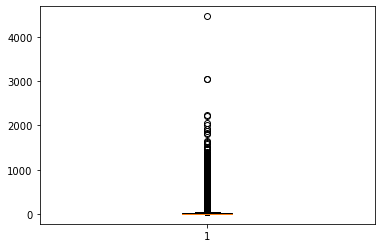

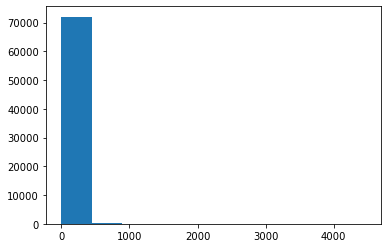

count    72537.000000
mean        30.255787
std         86.337406
min          0.000000
25%          1.000000
50%          4.000000
75%         22.000000
max       4468.000000
Name: tile_count, dtype: float64

0.77557660228573

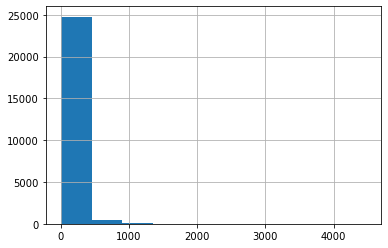

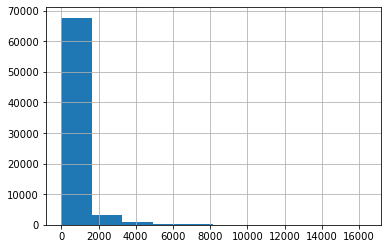

count    72513.000000
mean       359.605537
std        918.878666
min          0.000000
25%          0.000000
50%         20.780833
75%        212.018024
max      16357.357979
Name: solar_panel_area_divided_by_area, dtype: float64

In [6]:
_ = plt.boxplot(df['tile_count'])
plt.show()
_ = plt.hist(df['tile_count'])
plt.show()
df['tile_count'].describe()
len(df[df['tile_count'] > 0])/len(df)
df_tiles = df[df['tile_count'] >10]
_ = df_tiles['tile_count'].hist()
plt.show()
_ = df['solar_panel_area_divided_by_area'].hist()
plt.show()
df['solar_panel_area_divided_by_area'].describe()

In [7]:
df['solar_panel_area_divided_by_area'].describe()

count    72513.000000
mean       359.605537
std        918.878666
min          0.000000
25%          0.000000
50%         20.780833
75%        212.018024
max      16357.357979
Name: solar_panel_area_divided_by_area, dtype: float64

In [8]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 168 entries, tile_count to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(46), object(3)
memory usage: 92.0+ MB


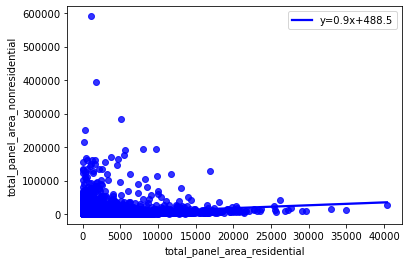

In [9]:
#plt.scatter(df['tile_count'], df['total_panel_area'])
# _ = sns.regplot(df['total_panel_area_residential'],df['total_panel_area_nonresidential'])
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['total_panel_area_residential'], df['total_panel_area_nonresidential'])
ax = sns.regplot(x = "total_panel_area_residential", y = "total_panel_area_nonresidential", data = df, color = 'b',
   line_kws = {
      'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)
   })

# plot legend
ax.legend()

In [10]:
len(df[df['solar_system_count_nonresidential'].isna()])

0

In [11]:
df['solar_system_count_nonresidential'].describe()

count    72537.000000
mean         2.602203
std          8.115283
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        397.000000
Name: solar_system_count_nonresidential, dtype: float64

In [12]:
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']


In [13]:
#Examine which look ahead variables are correlated
# res_cols = [col for col in look_ahead_vars if 'residential' in col and 'non' not in col]
# correlation_matrix = x_train[res_cols].corr()
# _ = sns.heatmap(correlation_matrix, annot=True)
# plt.show()
# nonres_cols = [col for col in look_ahead_vars if 'nonresidential' in col]
# correlation_matrix = x_train[nonres_cols].corr()
# _ = sns.heatmap(correlation_matrix, annot=True)
# plt.show()

In [14]:
#Might actually remove correlated columns in combination with the n/as and the distributions
# correlation_matrix = train_data.corr()
# corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
# corr_df = corr_df.reset_index()
# corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
# corr_cols = corr_df_significant['level_0'].unique()



In [15]:
#Print list of categorical columns
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['county',
 'state',
 'electricity_price_transportation',
 'voting_2016_dem_win',
 'voting_2012_dem_win']

In [16]:
df['electricity_price_transportation'] = pd.to_numeric(df['electricity_price_transportation'],errors='coerce')

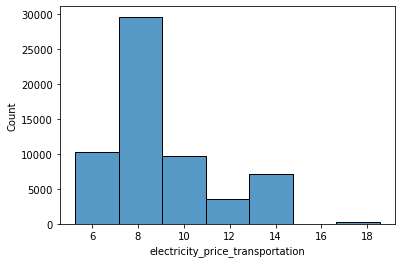

In [17]:
_ = sns.histplot(df['electricity_price_transportation'], bins=7)
_ = plt.show()

In [18]:
df['voting_2016_dem_win'] = np.where(df['voting_2016_dem_win'] == True, 1, 
                                    np.where(df['voting_2016_dem_win'] == False, 0, -1))
df['voting_2016_dem_win'].describe()

count    72537.000000
mean         0.540097
std          0.498393
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: voting_2016_dem_win, dtype: float64

In [19]:
df['voting_2012_dem_win'] = np.where(df['voting_2012_dem_win'] == True, 1, 
                                    np.where(df['voting_2012_dem_win'] == False, 0, -1))
df['voting_2012_dem_win'].describe()

count    72537.000000
mean         0.490108
std          0.499906
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: voting_2012_dem_win, dtype: float64

In [20]:
#Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

#define the target variable
target_var = 'solar_system_count_nonresidential'

look_ahead_vars.remove(target_var)
df = df.drop(look_ahead_vars, axis=1)
#df = df.drop(uninformative_vars, axis=1)


#Separate data into x and y
x = df[df.columns.difference([target_var])]
y = df[target_var]

#Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

train_data = pd.concat([x_train, pd.DataFrame(y_train.values, columns = [target_var], index = y_train.index)], axis=1)
train_data.head()

test_data = pd.concat([x_test, pd.DataFrame(y_test.values, columns = [target_var], index = y_test.index)], axis=1)


,age_10_14_rate,age_15_17_rate,age_18_24_rate,age_25_34_rate,age_35_44_rate,age_45_54_rate,age_55_64_rate,age_5_9_rate,age_65_74_rate,age_75_84_rate,age_median,age_more_than_85_rate,air_temperature,atmospheric_pressure,average_household_income,average_household_size,avg_electricity_retail_rate,cooling_degree_days,cooling_design_temperature,cooperate_tax,county,daily_solar_radiation,diversity,dropout_16_19_inschool_rate,earth_temperature,earth_temperature_amplitude,education_bachelor,education_bachelor_rate,education_college,education_college_rate,education_doctoral,education_doctoral_rate,education_high_school_graduate,education_high_school_graduate_rate,education_less_than_high_school,education_less_than_high_school_rate,education_master,education_master_rate,education_population,education_professional_school,education_professional_school_rate,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_residential,electricity_consume_total,electricity_price_commercial,electricity_price_industrial,electricity_price_overall,electricity_price_residential,electricity_price_transportation,elevation,employ_rate,employed,feedin_tariff,fips,frost_days,gini_index,health_insurance_none_rate,health_insurance_public_rate,heating_degree_days,heating_design_temperature,heating_fuel_coal_coke,heating_fuel_coal_coke_rate,heating_fuel_electricity,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_gas,heating_fuel_gas_rate,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_none_rate,heating_fuel_other,heating_fuel_other_rate,heating_fuel_solar,heating_fuel_solar_rate,household_count,household_type_family_rate,housing_unit_count,housing_unit_median_gross_rent,housing_unit_median_value,housing_unit_occupied_count,incentive_count_nonresidential,incentive_count_residential,incentive_nonresidential_state_level,incentive_residential_state_level,land_area,lat,lon,median_household_income,mortgage_with_rate,net_metering,number_of_years_of_education,occupancy_owner_rate,occupancy_vacant_rate,occupation_administrative_rate,occupation_agriculture_rate,occupation_arts_rate,occupation_construction_rate,occupation_education_rate,occupation_finance_rate,occupation_information_rate,occupation_manufacturing_rate,occupation_public_rate,occupation_retail_rate,occupation_transportation_rate,occupation_wholesale_rate,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_below_poverty_level_rate,poverty_family_count,property_tax,race_asian,race_asian_rate,race_black_africa,race_black_africa_rate,race_indian_alaska,race_indian_alaska_rate,race_islander,race_islander_rate,race_other,race_other_rate,race_two_more,race_two_more_rate,race_white,race_white_rate,rebate,relative_humidity,sales_tax,state,total_area,transportation_bicycle_rate,transportation_car_alone_rate,transportation_carpool_rate,transportation_home_rate,transportation_motorcycle_rate,transportation_public_rate,transportation_walk_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,travel_time_average,travel_time_less_than_10_rate,unemployed,voting_2012_dem_percentage,voting_2012_dem_win,voting_2012_gop_percentage,voting_2016_dem_percentage,voting_2016_dem_win,voting_2016_gop_percentage,water_area,wind_speed,solar_system_count_nonresidential
40203,0.050958,0.041469,0.052891,0.194342,0.161307,0.202776,0.109120,0.033737,0.083817,0.027763,41.2,0.013530,8.6,96.6,90330.081301,2.10,7.25,659.0,21.96,0,King County,3.35,0.462870,1.000000,9.0,14.81,1280,0.283751,1352,0.299712,0,0.000000,978,0.216803,390,0.086455,455,0.100865,4511,56,0.012414,6680,76502,964,84146,8.22,4.35,7.40,9.09,8.18,433.0,0.927165,3437,11,53033025301,70.0,0.3979,0.094978,0.185903,3430.0,-2.52,0,0.000000,1798,0.664449,68,0.025129,827,0.305617,2706,13,0.004804,0,0.000000,0,0.0,2706,0.469327,3090,1422.0,416200.0,2706,30,23,11,8,1.475531,47.505,-1

In [21]:
na_cols = find_na_columns(df)
na_cols

['average_household_income',
 'gini_index',
 'land_area',
 'per_capita_income',
 'population_density',
 'total_area',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 'education_bachelor_rate',
 'education_master_rate',
 'education_professional_school_rate',
 'education_doctoral_rate',
 'race_white_rate',
 'race_black_africa_rate',
 'race_indian_alaska_rate',
 'race_asian_rate',
 'race_islander_rate',
 'race_other_rate',
 'race_two_more_rate',
 'employ_rate',
 'poverty_family_below_poverty_level_rate',
 'heating_fuel_gas_rate',
 'heating_fuel_electricity_rate',
 'heating_fuel_fuel_oil_kerosene_rate',
 'heating_fuel_coal_coke_rate',
 'heating_fuel_solar_rate',
 'heating_fuel_other_rate',
 'heating_fuel_none_rate',
 'median_household_income',
 'electricity_price_transportation',
 'average_household_size',
 'housing_unit_median_value',
 'housing_unit_median_gross_rent',
 'lat',
 'lon',
 'elevation',
 'heating_desig

In [22]:
for col in na_cols:
    train_data, test_data = impute_values(train_data, test_data, col,'county', 'median')

In [23]:
na_cols = find_na_columns(train_data)
na_cols

['age_10_14_rate',
 'age_15_17_rate',
 'age_18_24_rate',
 'age_25_34_rate',
 'age_35_44_rate',
 'age_45_54_rate',
 'age_55_64_rate',
 'age_5_9_rate',
 'age_65_74_rate',
 'age_75_84_rate',
 'age_median',
 'age_more_than_85_rate',
 'air_temperature',
 'atmospheric_pressure',
 'average_household_income',
 'average_household_size',
 'cooling_degree_days',
 'cooling_design_temperature',
 'daily_solar_radiation',
 'diversity',
 'dropout_16_19_inschool_rate',
 'earth_temperature',
 'earth_temperature_amplitude',
 'education_bachelor_rate',
 'education_college_rate',
 'education_doctoral_rate',
 'education_high_school_graduate_rate',
 'education_less_than_high_school_rate',
 'education_master_rate',
 'education_professional_school_rate',
 'electricity_price_transportation',
 'elevation',
 'employ_rate',
 'frost_days',
 'gini_index',
 'health_insurance_none_rate',
 'health_insurance_public_rate',
 'heating_degree_days',
 'heating_design_temperature',
 'heating_fuel_coal_coke_rate',
 'heating_fu

In [24]:
for col in na_cols:
    print(col, ' has ', len(train_data[train_data[col].isna()]), ' missing')

age_10_14_rate  has  1  missing
age_15_17_rate  has  1  missing
age_18_24_rate  has  1  missing
age_25_34_rate  has  1  missing
age_35_44_rate  has  1  missing
age_45_54_rate  has  1  missing
age_55_64_rate  has  1  missing
age_5_9_rate  has  1  missing
age_65_74_rate  has  1  missing
age_75_84_rate  has  1  missing
age_median  has  1  missing
age_more_than_85_rate  has  1  missing
air_temperature  has  11  missing
atmospheric_pressure  has  11  missing
average_household_income  has  1  missing
average_household_size  has  1  missing
cooling_degree_days  has  11  missing
cooling_design_temperature  has  11  missing
daily_solar_radiation  has  11  missing
diversity  has  1  missing
dropout_16_19_inschool_rate  has  2  missing
earth_temperature  has  11  missing
earth_temperature_amplitude  has  11  missing
education_bachelor_rate  has  1  missing
education_college_rate  has  1  missing
education_doctoral_rate  has  1  missing
education_high_school_graduate_rate  has  1  missing
educatio

In [25]:
#Drop the columns that had almost 5,000 rows of missing data.
drop_cols = ['electricity_price_transportation','voting_2012_dem_percentage','voting_2012_gop_percentage']
train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [26]:
'voting_2012_dem_percentage' in train_data.columns

False

In [27]:
len(train_data)

58029

In [28]:
#Drop any remaining rows with n/a values
train_data = train_data.dropna()
len(train_data)
test_data = test_data.dropna()
len(test_data)

58012

14501

In [29]:
#Define variables that are uniformative for what the model is trying to predict
uninformative_vars = ['fips', 'county', 'state']
#'lat', 'lon'
train_data = train_data.drop(uninformative_vars, axis=1)
test_data = test_data.drop(uninformative_vars, axis=1)

In [30]:
# # corr_cols = ['placeholder']
# # dropped_cols = []
# # while len(corr_cols) > 0:
# correlation_matrix = train_data.corr()
# corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
# corr_df = corr_df.reset_index()
# corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
# corr_cols = corr_df_significant['level_0'].unique()
# if target_var in corr_cols:
#     corr_cols.remove(target_var)
# subset = corr_df[(corr_df['level_0'] ==target_var)&(corr_df['level_1'].isin(corr_cols))]
# subset['correlation_coef'] = abs(subset['correlation_coef'])

# drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
# drop_col
# # dropped_cols.append(drop_col)
# # df = df.drop(drop_col, axis=1)


In [31]:
correlation_matrix = train_data.corr()
corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
corr_df = corr_df.reset_index()
corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
len(corr_df_significant['level_0'].unique())

72

In [32]:
train_data, dropped_cols = remove_correlation(train_data, target_var)

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_28981/238850017.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['correlation_coef'] = abs(subset['correlation_coef'])


In [33]:
test_data = test_data.drop(dropped_cols, axis=1)

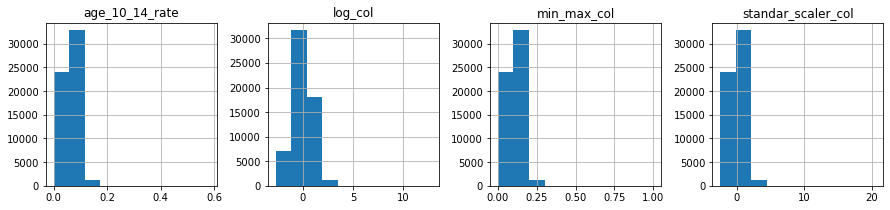

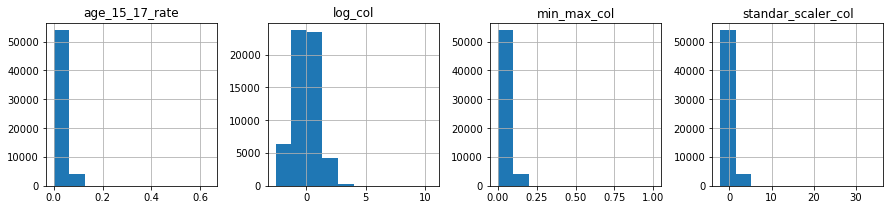

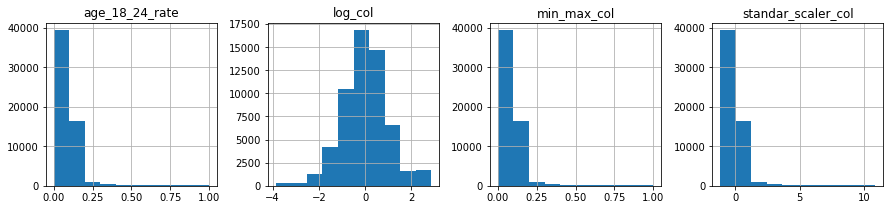

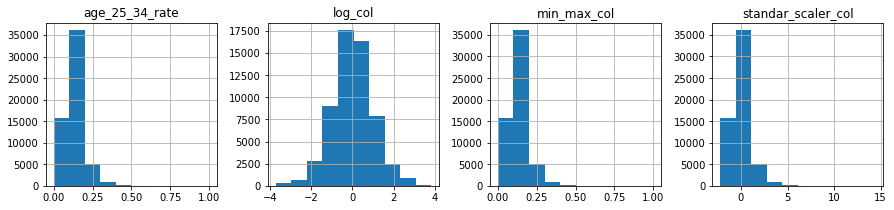

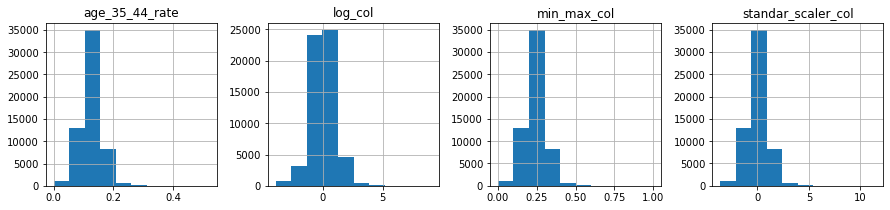

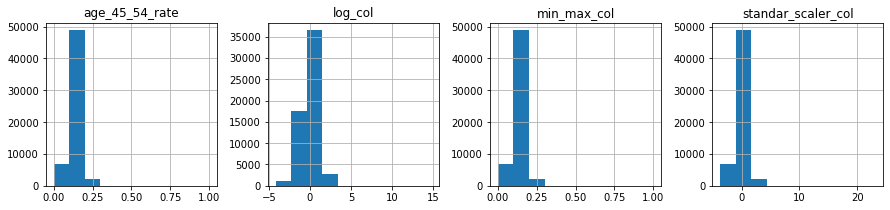

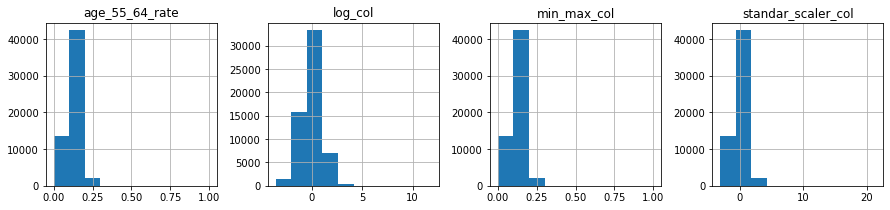

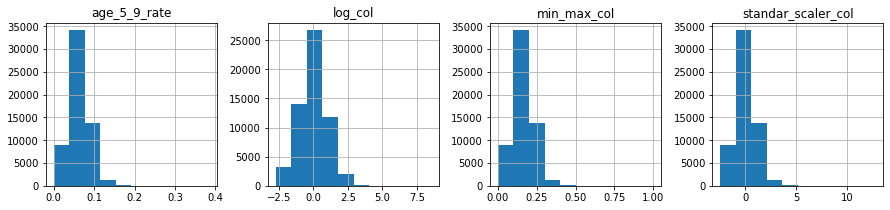

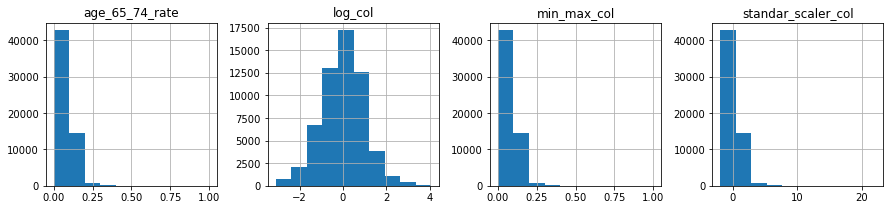

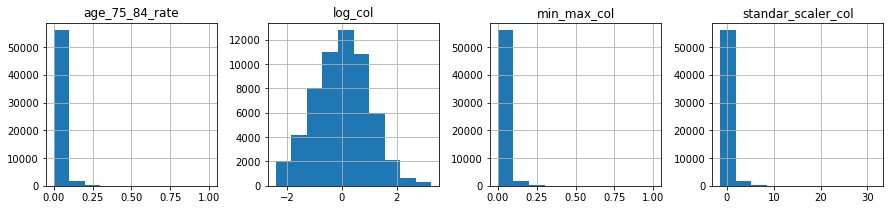

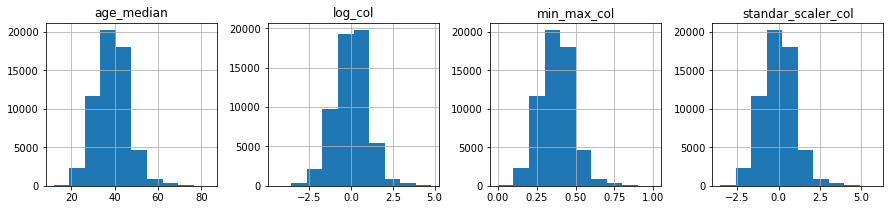

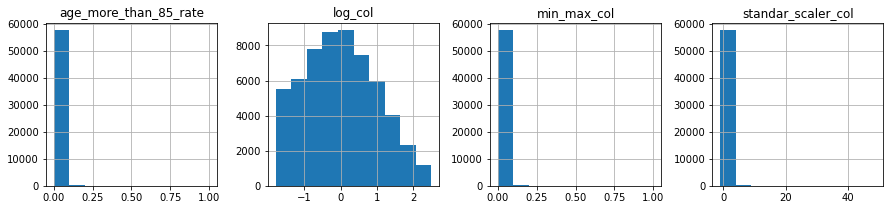

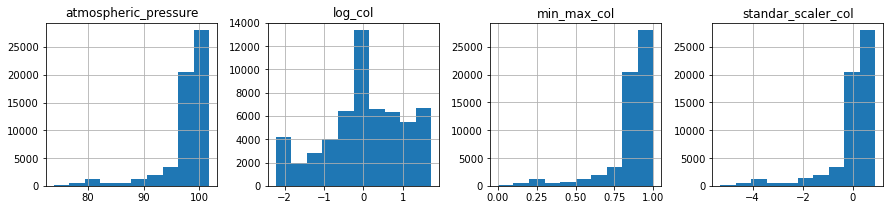

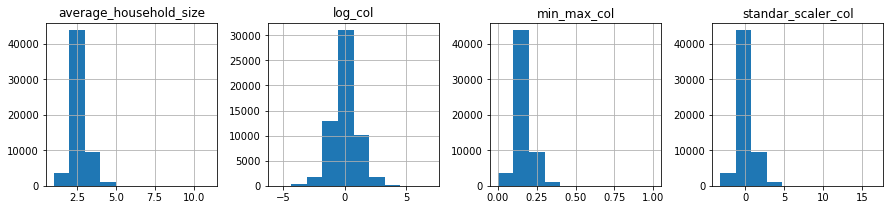

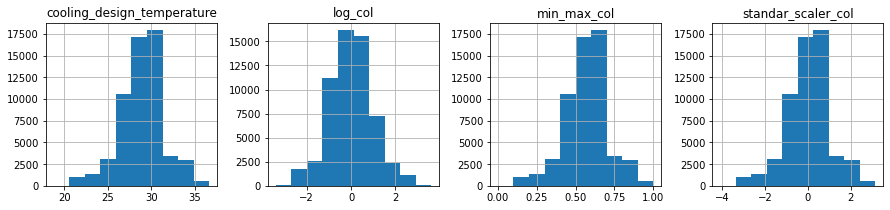

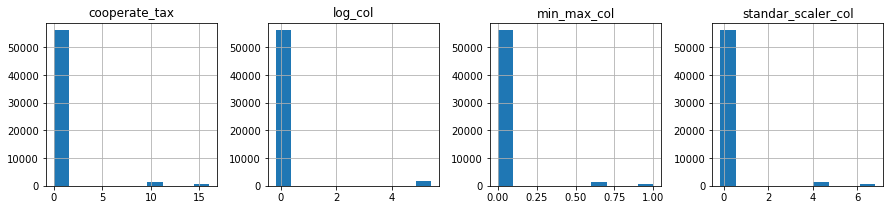

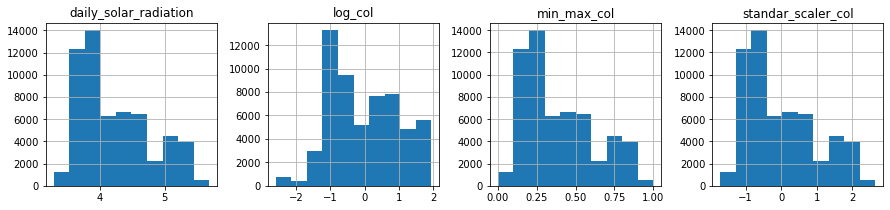

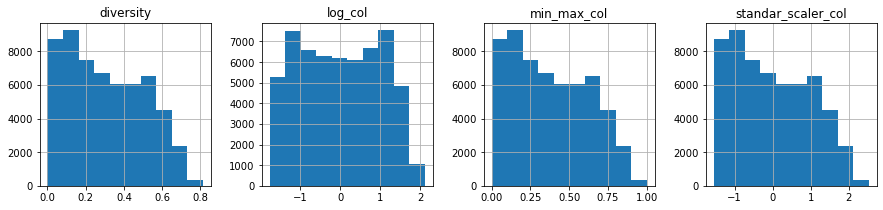

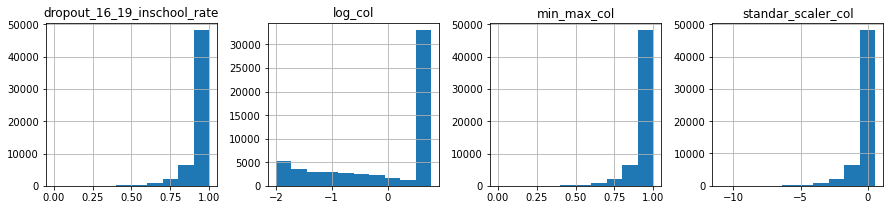

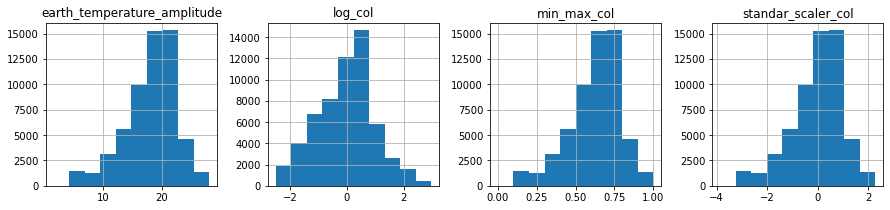

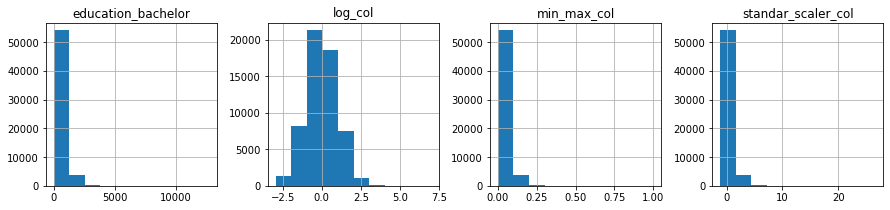

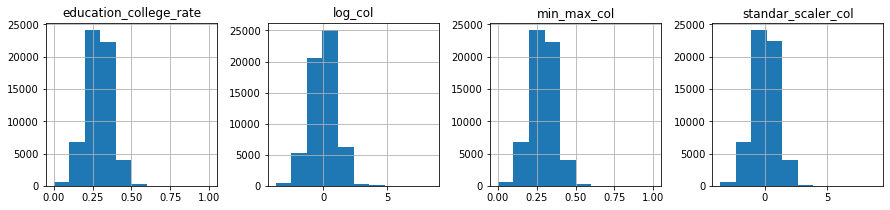

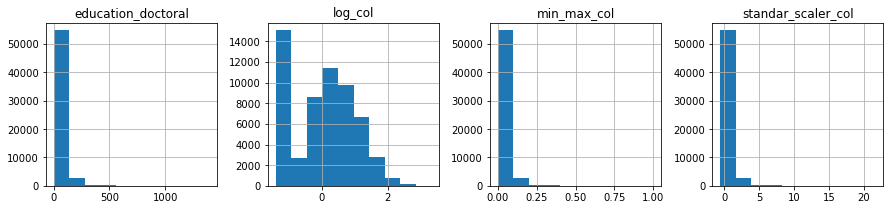

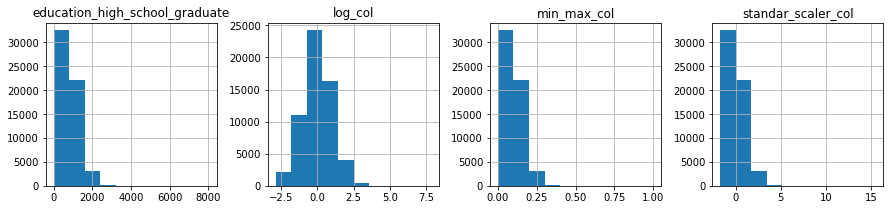

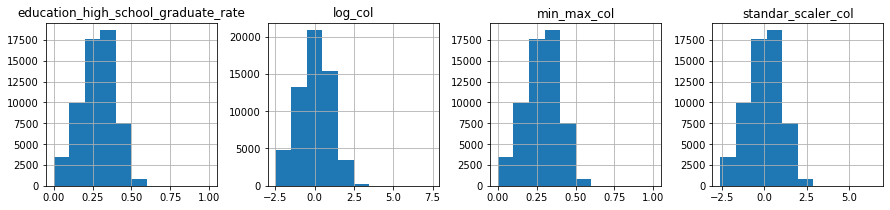

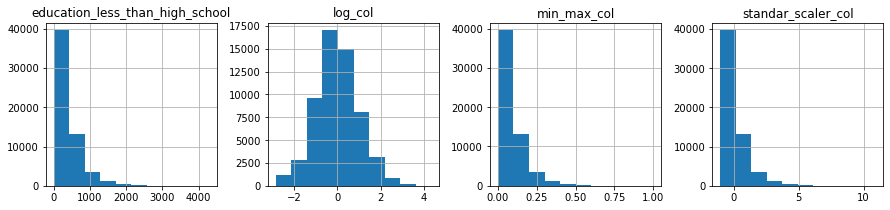

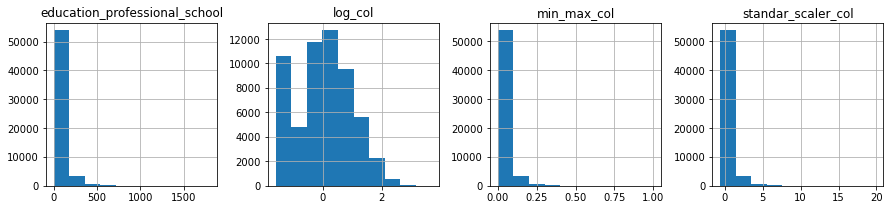

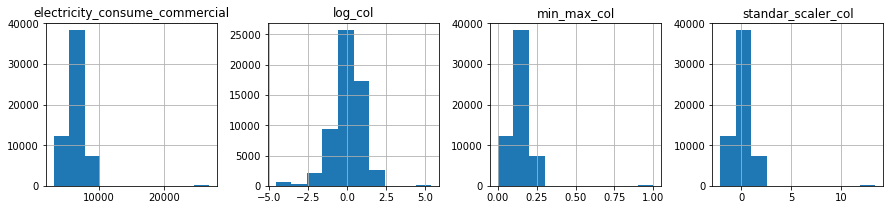

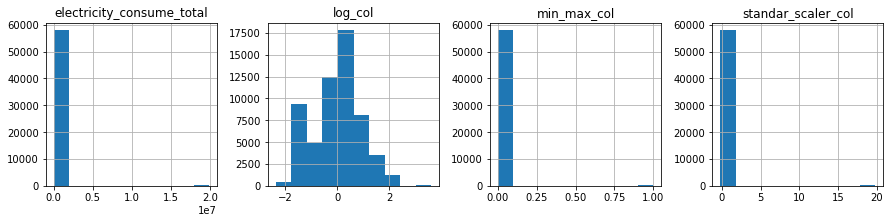

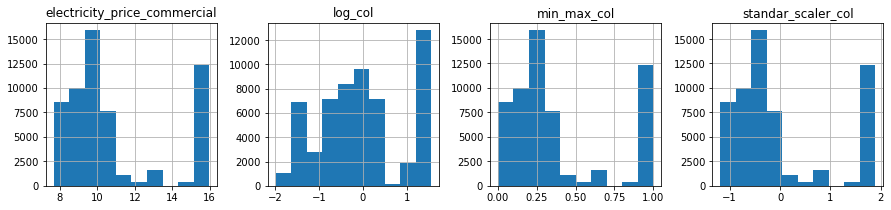

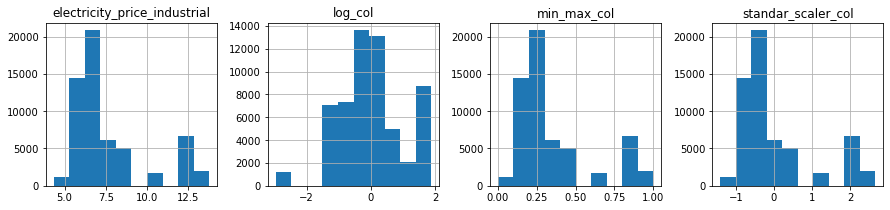

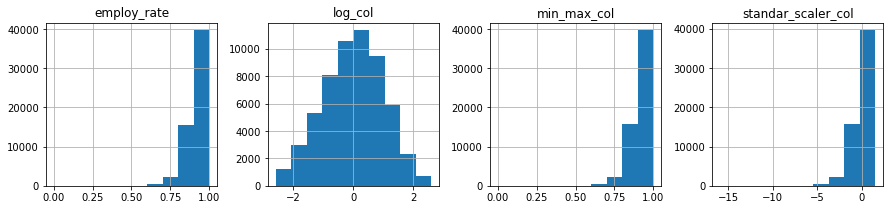

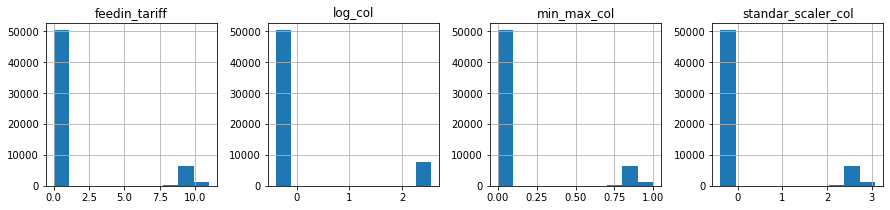

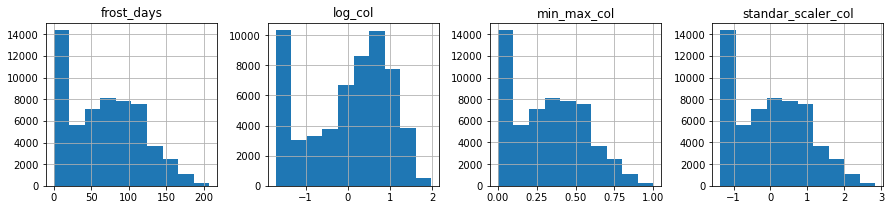

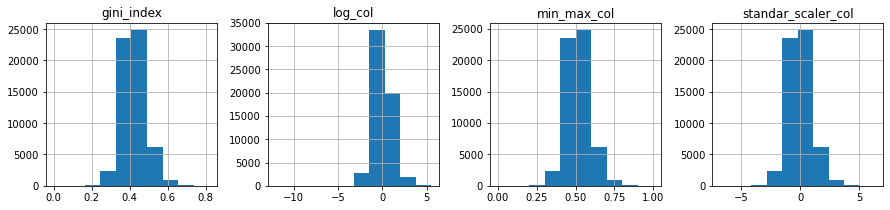

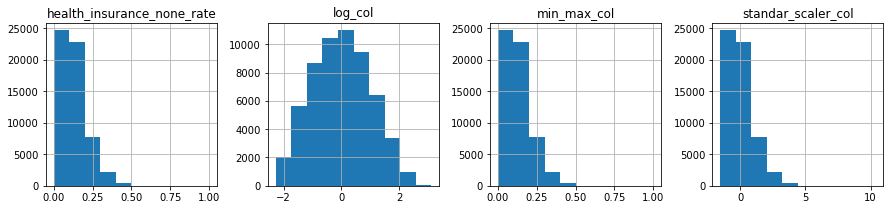

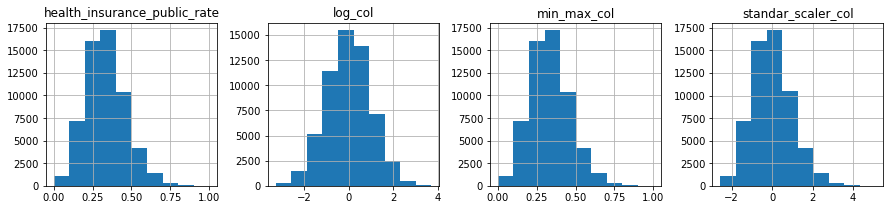

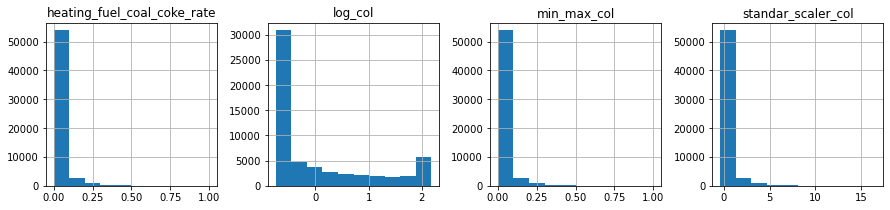

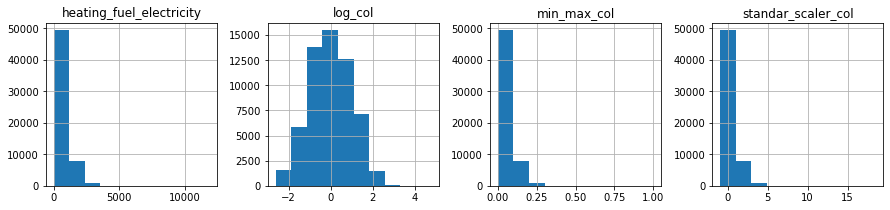

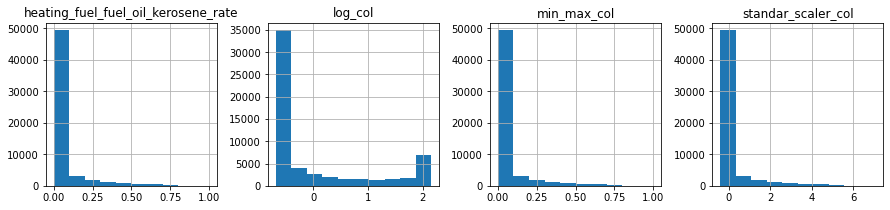

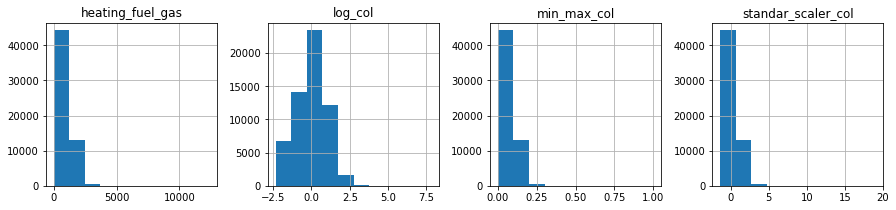

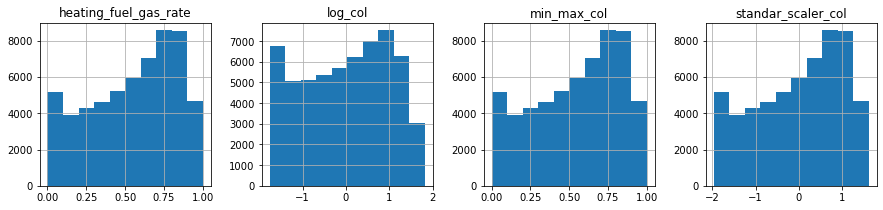

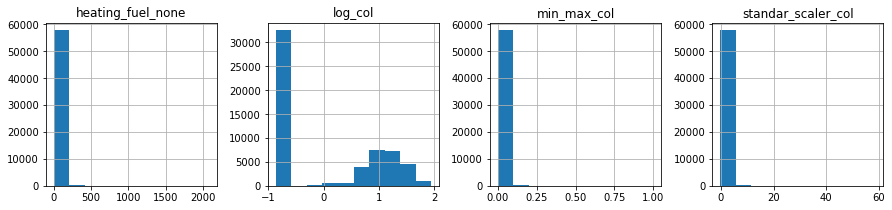

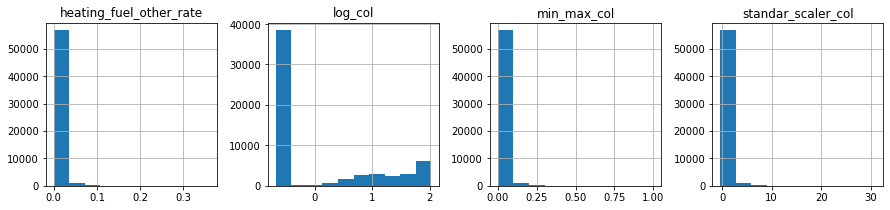

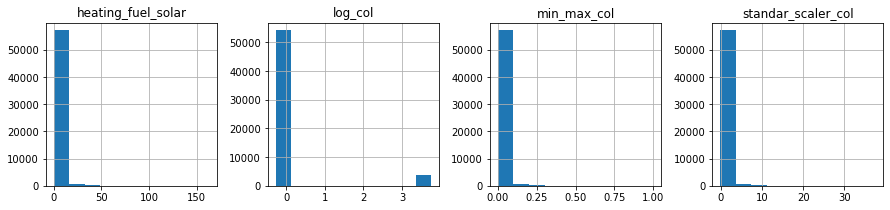

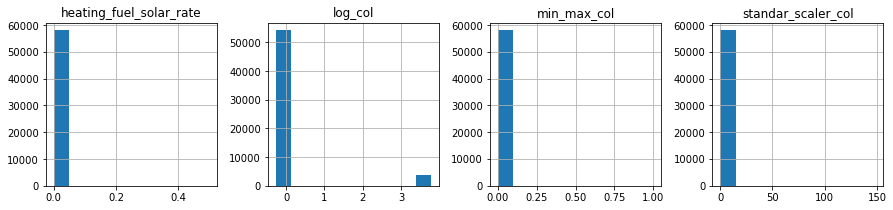

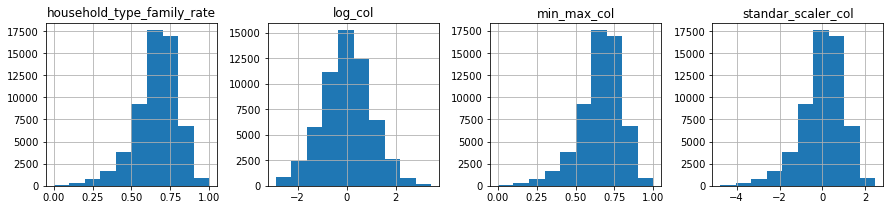

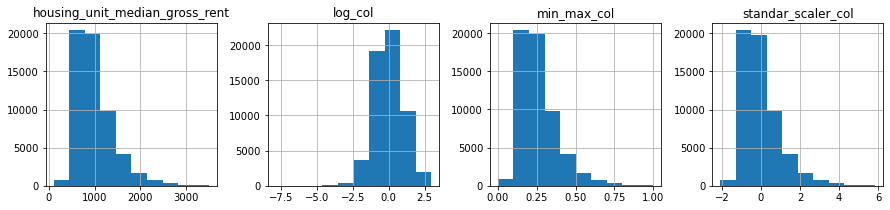

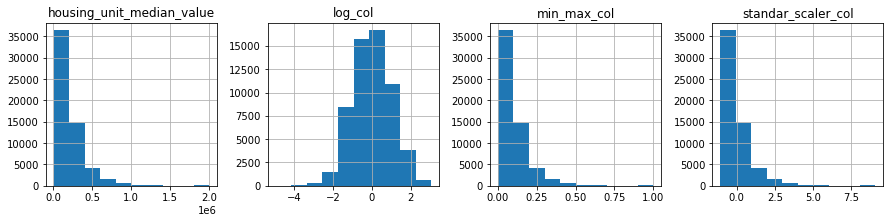

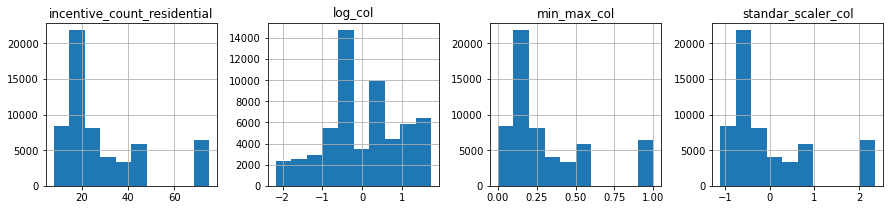

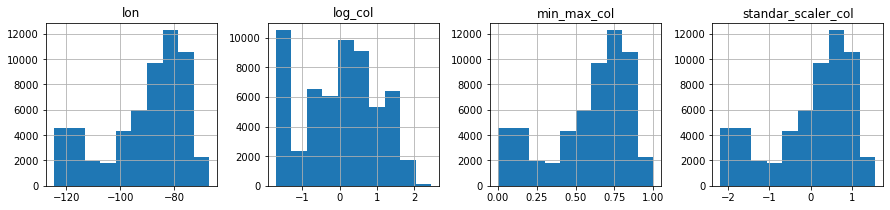

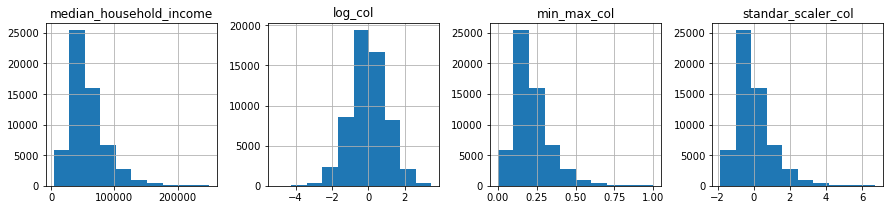

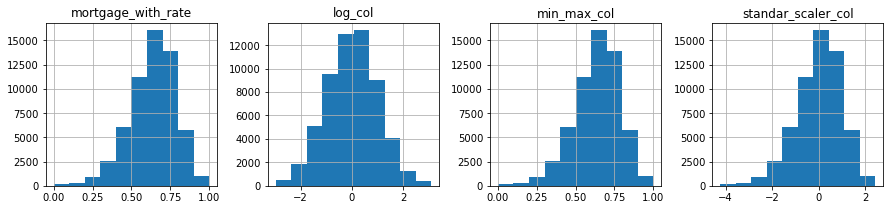

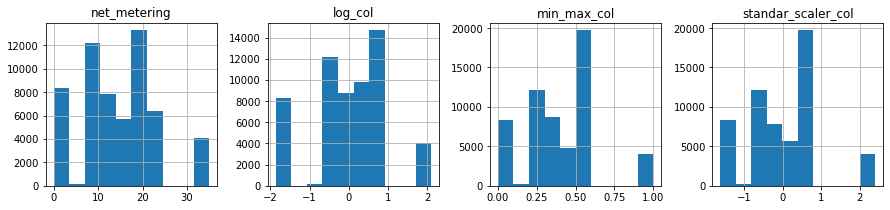

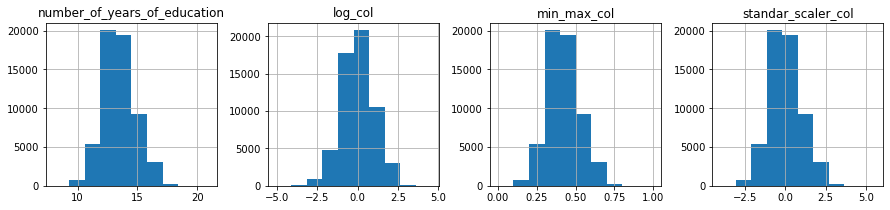

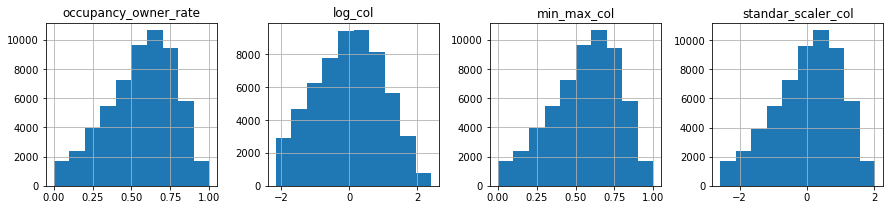

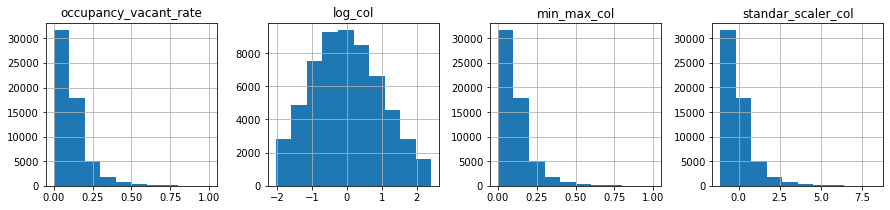

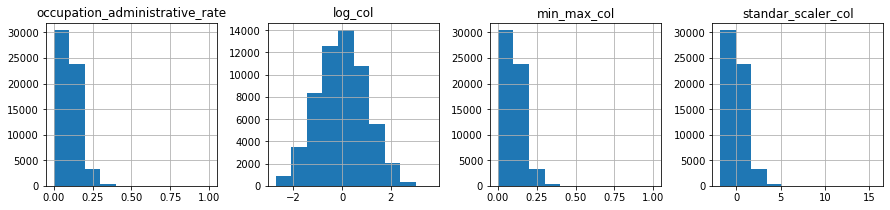

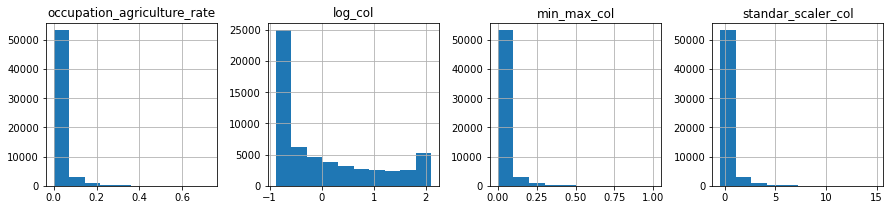

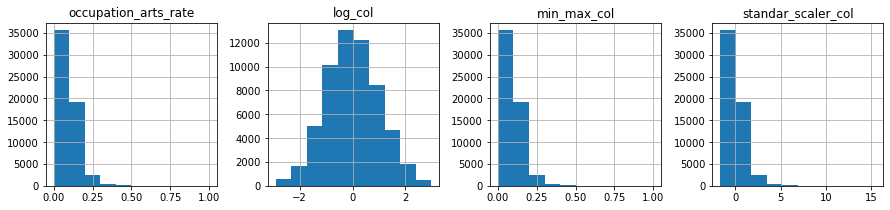

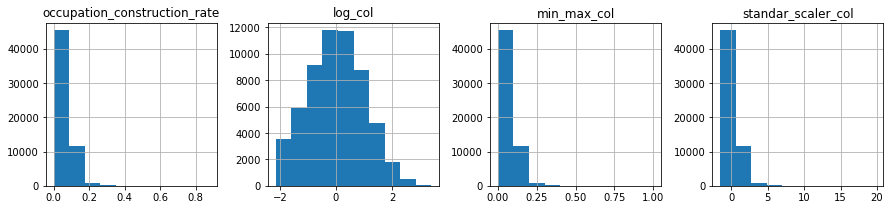

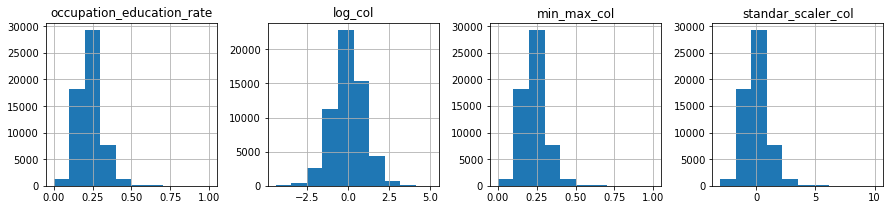

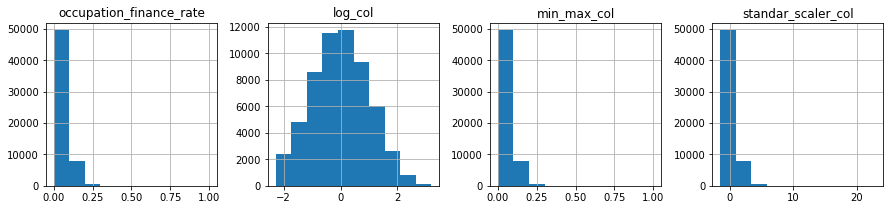

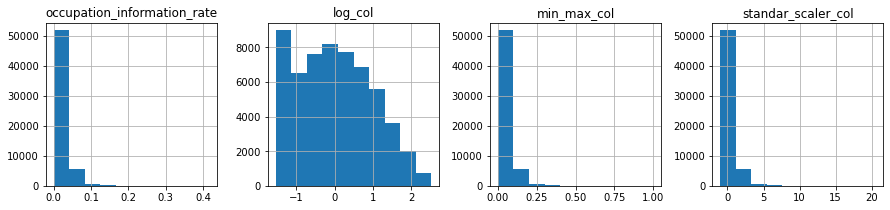

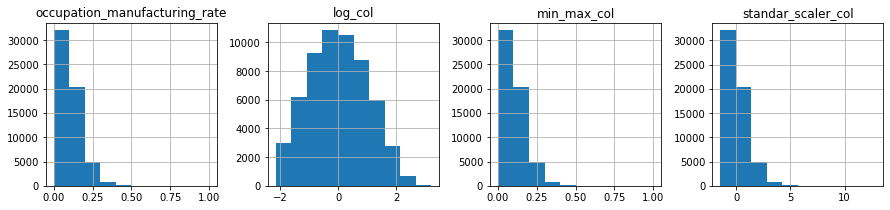

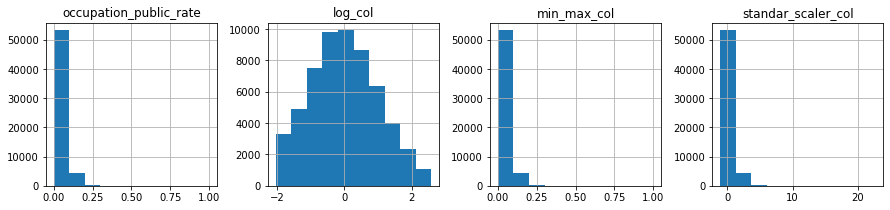

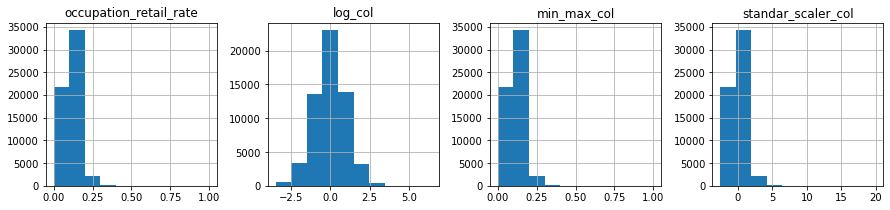

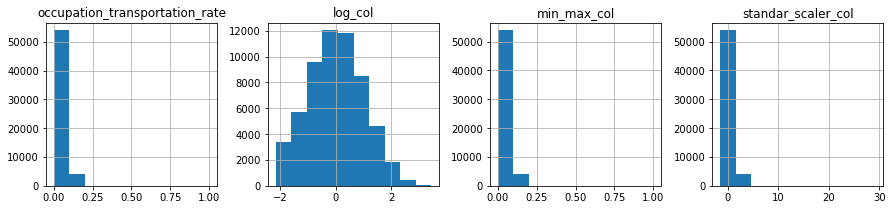

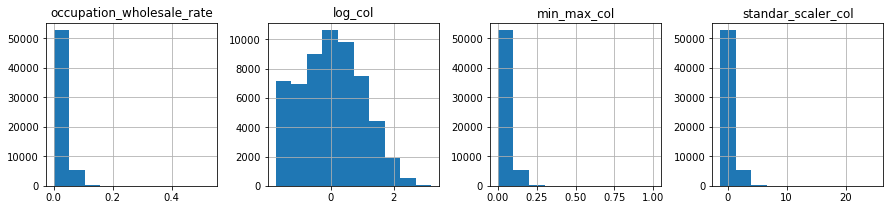

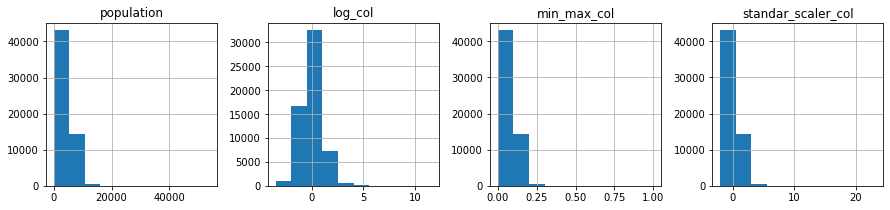

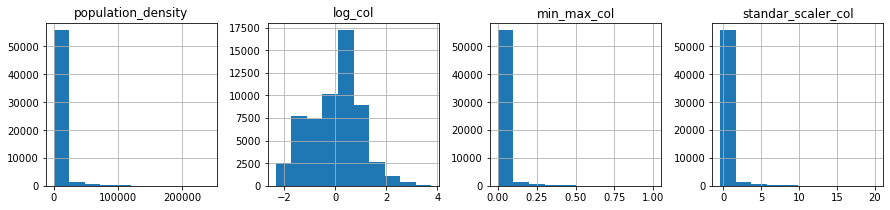

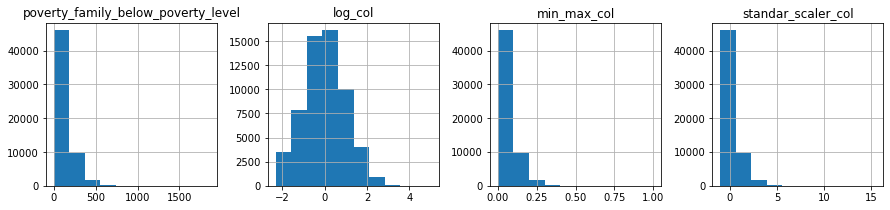

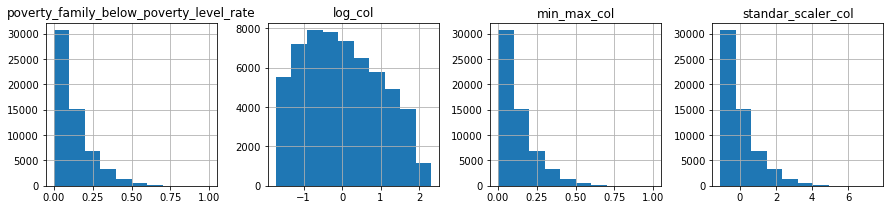

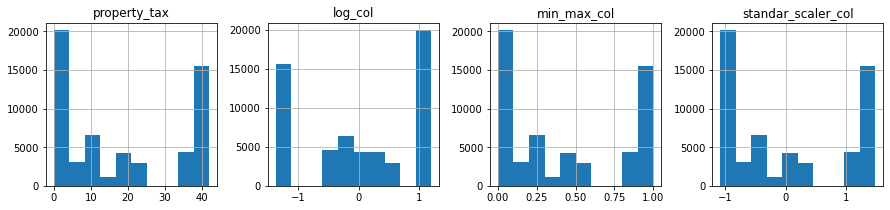

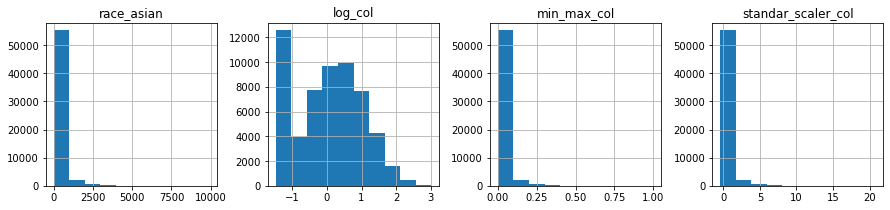

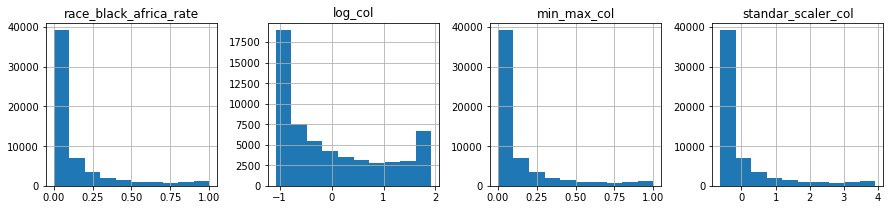

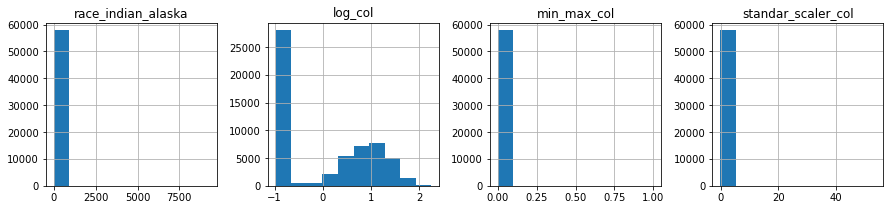

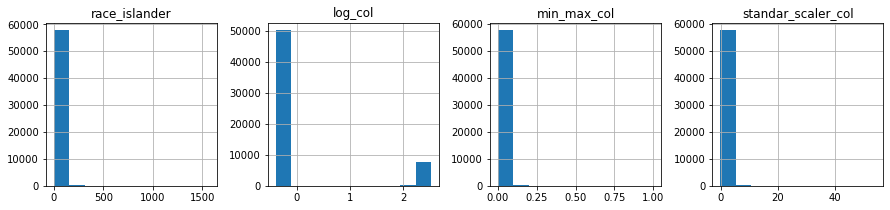

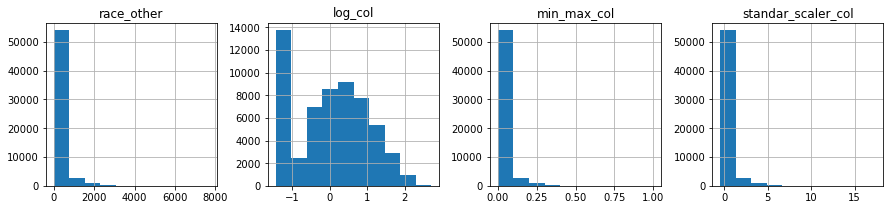

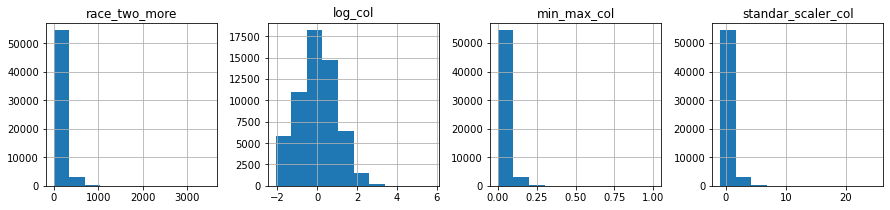

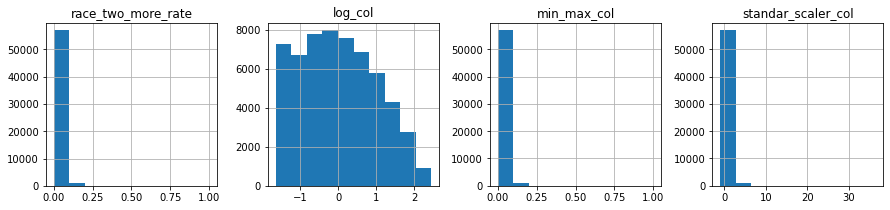

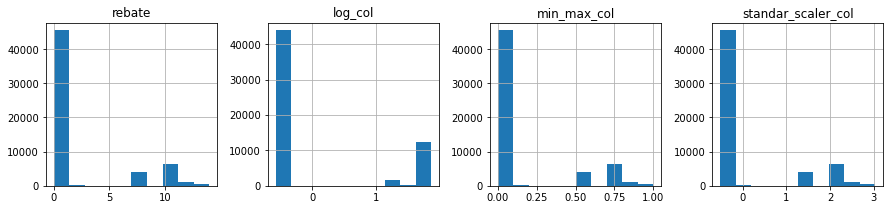

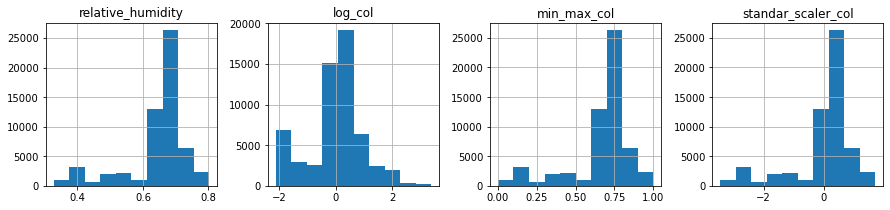

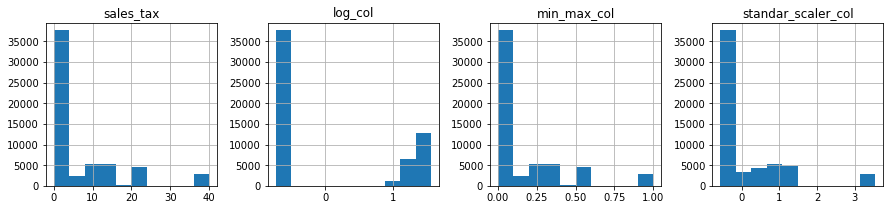

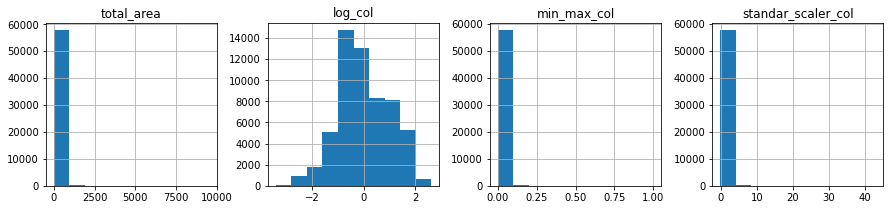

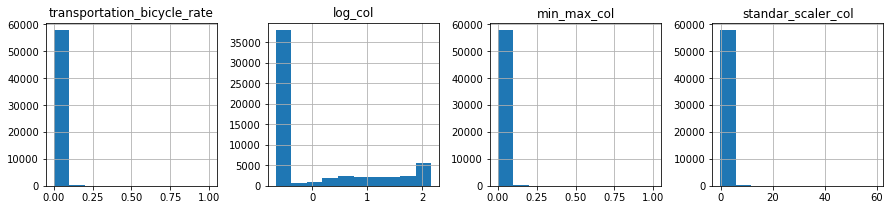

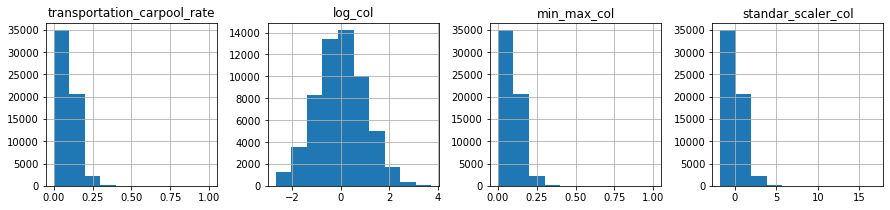

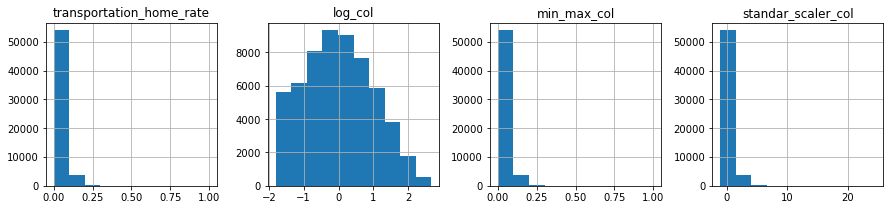

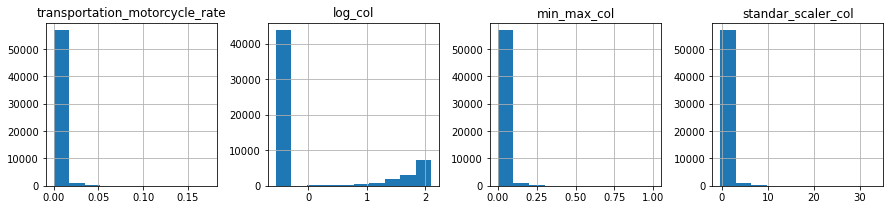

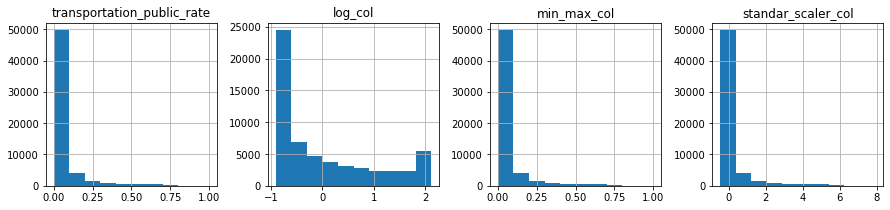

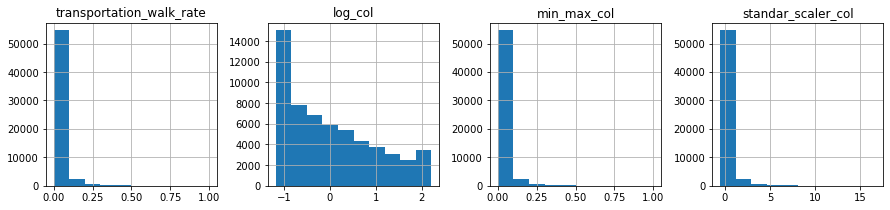

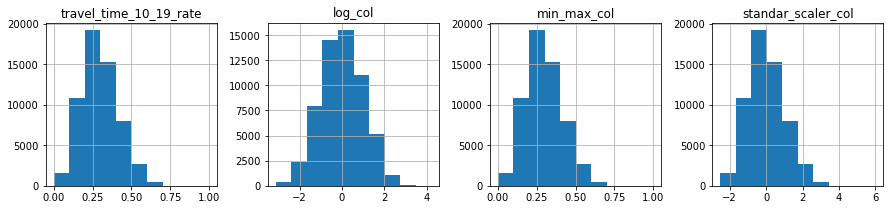

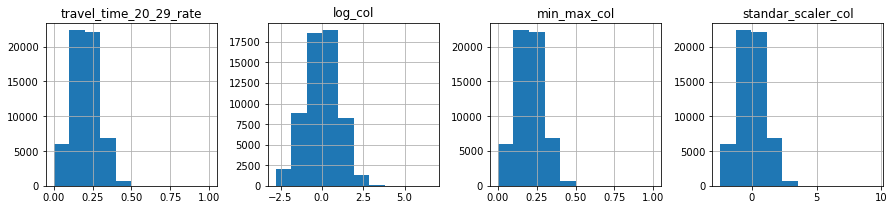

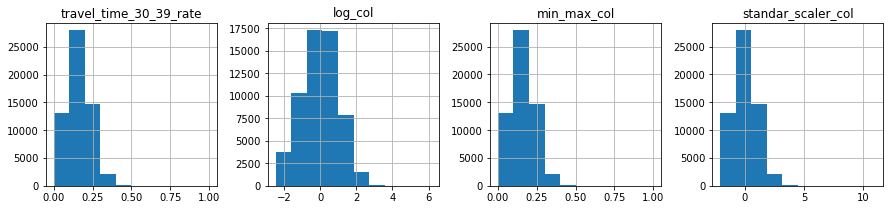

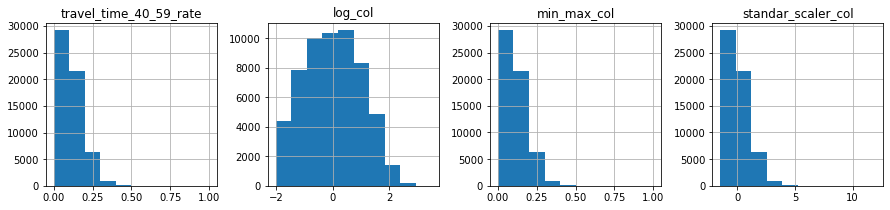

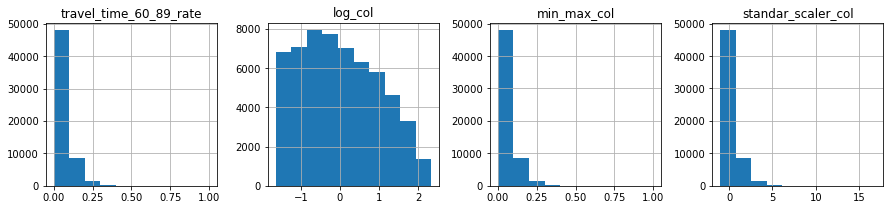

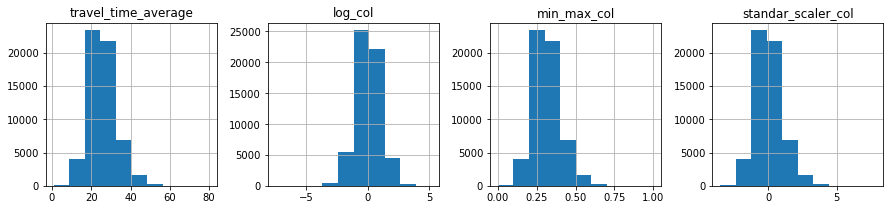

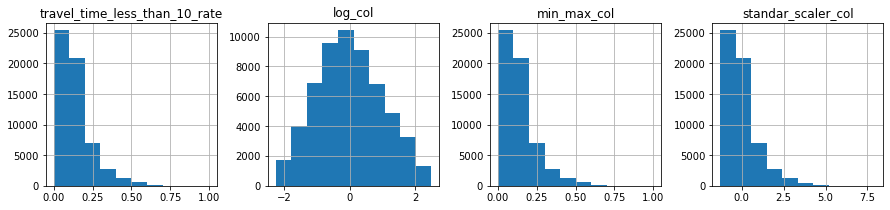

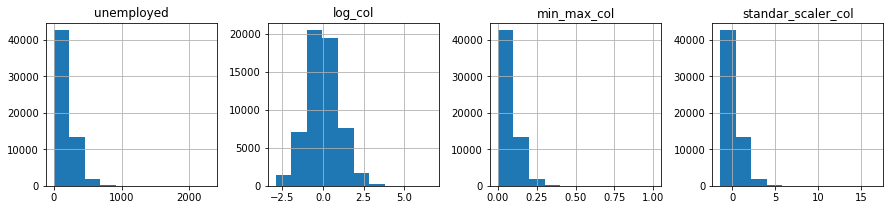

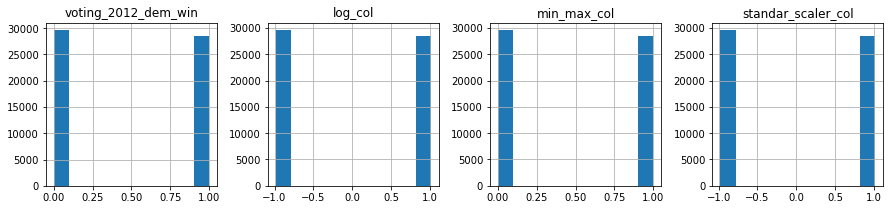

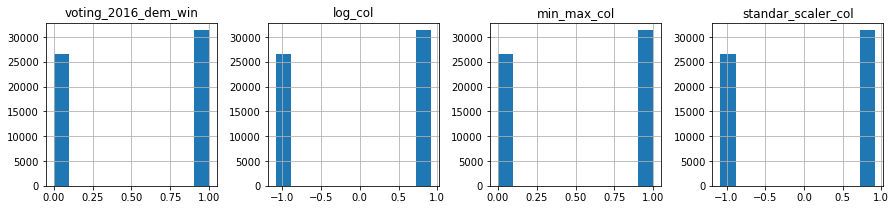

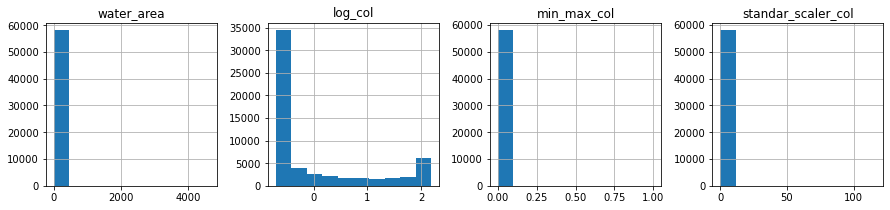

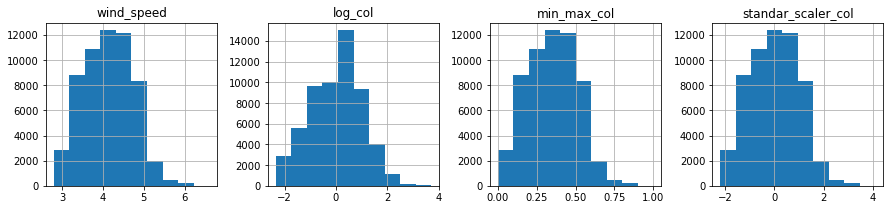

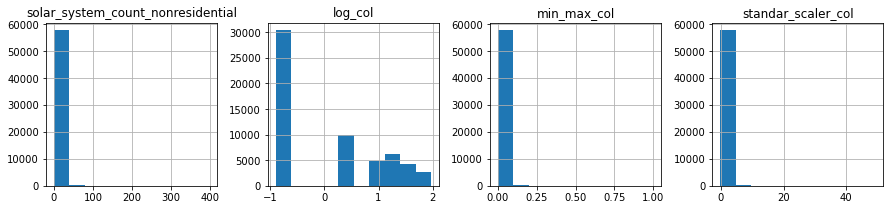

In [34]:
#Investigate distribution of values for numeric columns - determine type of transformation to fix scewness and 
#scale discrepencies in the data
no_plot = list()
for col in list(train_data.select_dtypes(include=[np.number]).columns.values):
    try:
        transformation_comparison(train_data, col)
    except:
        no_plot.append(col)
        continue

In [35]:
no_plot

[]

From the distributions above, the log transformation does the best job of making the distributions more Gaussian. Will apply this transformation to all of the data.

In [36]:
train_data = train_data.drop(['log_col', 'min_max_col', 'standar_scaler_col'], axis=1)

In [37]:
numeric_cols = list(train_data.select_dtypes(include=[np.number]).columns.values)
pos_cols = [col for col in numeric_cols if train_data[col].min() > 0 and test_data[col].min() > 0 and col not in no_plot]
nonpos_cols = [col for col in numeric_cols if col not in pos_cols and col not in no_plot and col != target_var]

#Use box-cox method to transform positive columns
pt = PowerTransformer('box-cox')
print(pt.fit(train_data[pos_cols]))
train_data[pos_cols] = pt.transform(train_data[pos_cols])
test_data[pos_cols] = pt.transform(test_data[pos_cols])

#Use yeo-johnson method to transform columns with negative values
pt2 = PowerTransformer('yeo-johnson')
print(pt2.fit(train_data[nonpos_cols]))
train_data[nonpos_cols] = pt2.transform(train_data[nonpos_cols])
test_data[nonpos_cols] = pt2.transform(test_data[nonpos_cols])

PowerTransformer(method='box-cox')
PowerTransformer()


In [38]:
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']

In [39]:
# df_classification = df.copy()
# df_classification['tile_present'] = np.where(df_classification['tile_count'] > 0, 1, 0)
# df_classification = df_classification.drop(look_ahead_vars, axis=1)
# #Define the binary target variable for classification model
# binary_var = 'tile_present'
# #Separate data into x and y
# x = df_classification[df_classification.columns.difference([binary_var])]
# y = df_classification[binary_var]

In [40]:
# target_var = 'total_panel_area_residential'
# #look_ahead_vars.remove('total_panel_area_residential')
# #df_regression = df.drop(look_ahead_vars, axis=1)
# #Separate data into x and y
# x_reg = df_regression[df_regression.columns.difference([target_var])]
# y_reg = df_regression[target_var]

In [41]:
target_var = 'solar_system_count_nonresidential'
train_labels = train_data[target_var]
train_data = train_data[train_data.columns.difference([target_var])]
test_labels = test_data[target_var]
test_data = test_data[test_data.columns.difference([target_var])]

# Model Creation

## XGBoost Model Residential

In [42]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================

# XGB parameters (extreme gradient boosting)
params_xgb = {'reg_lambda': 2,
 'reg_alpha': 0.2,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 20,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.8,
 'booster': 'gbtree'}

In [43]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model = XGBRegressor(**params_xgb)

In [44]:
%%time
model.fit(train_data, train_labels)

CPU times: user 24min, sys: 10.2 s, total: 24min 10s
Wall time: 3min 17s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.2, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

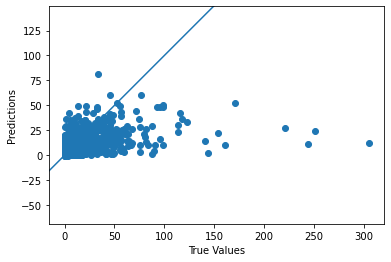

In [46]:
test_predictions = model.predict(test_data)

_ = plt.scatter(test_labels, test_predictions)
_ = plt.xlabel('True Values')
_ = plt.ylabel('Predictions')
_ = plt.axis('equal')
_ = plt.xlim(plt.xlim())
_ = plt.ylim(plt.ylim())
_ = plt.plot([-1000, 1000], [-1000, 1000])
plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/xgboost_nonresidential_system_count_errors.png")

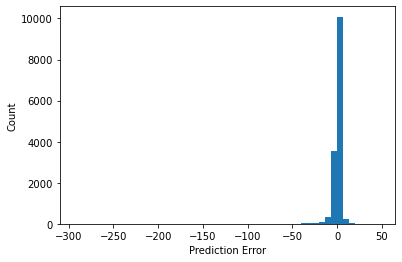

In [47]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_errors_hist.png")

In [48]:
mse = round(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 49


In [49]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df['feature_importance'] > .01]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return(fi_df)

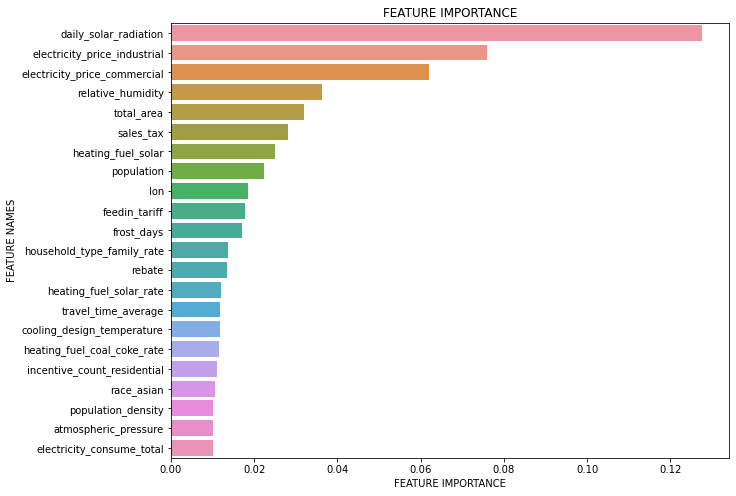

In [50]:
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_feature_importance.png")

In [51]:
#Save model
pickle.dump(model, open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_nonresidential_solar_system_count.sav', 'wb'))


In [68]:
#load saved model
#loaded_model = pickle.load(open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential.sav', 'rb'))
# plot_feature_importance(loaded_model.feature_importances_, train_data.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


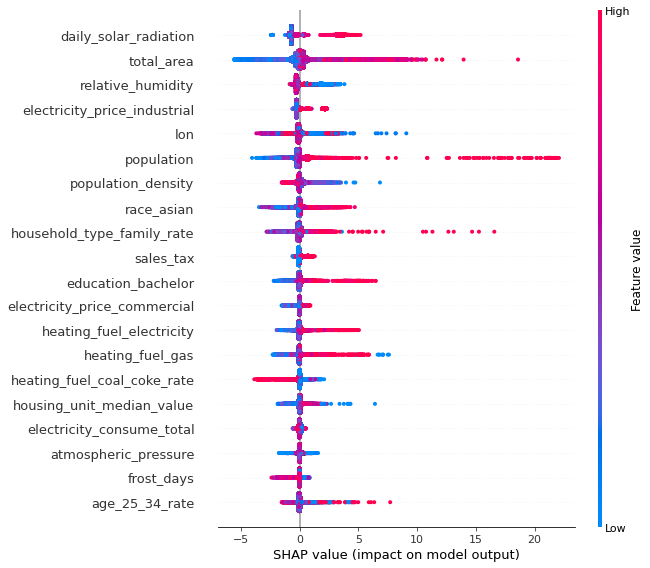

<Figure size 432x288 with 0 Axes>

In [62]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data, approximate=True)
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_system_count_shap.png")

In [52]:
# parameters = {'objective':['reg:squarederror'],
#               'booster':['gbtree','gblinear'],
#               'learning_rate': [.01, 0.1], 
#               'max_depth': [7,10,20],
#               'min_child_weight': [1, 10 ,20,25],
#               'colsample_bytree': [0.8, 0.9, 1],
#               'n_estimators': [300,500,600, 1000],
#               "reg_alpha"   : [0.5,0.2,1],
#               "reg_lambda"  : [0, 2,3,5],
#               "gamma"       : [0, 1 ,3]}
# random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
#                                            n_iter=100, cv=5, verbose=3, random_state=seed,
#                                            n_jobs=-1, scoring = 'neg_mean_absolute_error')
# random_search.fit(train_data, train_labels)


In [53]:
# random_search.best_params_

In [54]:
# params_xgb = {'reg_lambda': 2,
#  'reg_alpha': 0.2,
#  'objective': 'reg:squarederror',
#  'n_estimators': 300,
#  'min_child_weight': 10,
#  'max_depth': 20,
#  'learning_rate': 0.01,
#  'gamma': 0,
#  'colsample_bytree': 0.8,
#  'booster': 'gbtree'}
# #======================================================
# # define the model, uncomment the one you want to use
# #======================================================
# #model = RandomForestRegressor(**params_rfr)
# model = XGBRegressor(**params_xgb)

In [55]:
# %%time
# model.fit(train_data, train_labels)

In [56]:
# test_predictions = model.predict(test_data)

# _ = plt.scatter(test_labels, test_predictions)
# _ = plt.xlabel('True Values')
# _ = plt.ylabel('Predictions')
# _ = plt.axis('equal')
# _ = plt.xlim(plt.xlim())
# _ = plt.ylim(plt.ylim())
# _ = plt.plot([-1000, 1000], [-1000, 1000])
# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_errors.png")

In [57]:
# mse = round(mean_squared_error(test_labels, test_predictions))
# print(f'the mse is {mse}')

In [58]:
# fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_feature_importance.png")

In [59]:
# # histogram
# error = test_predictions - test_labels
# _ = plt.hist(error, bins = 50)
# _ = plt.xlabel("Prediction Error")
# _ = plt.ylabel("Count")
# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_errors_hist.png")

In [60]:
# import shap
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(train_data, approximate=True)
# shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_nonresidential_tuned_system_count_shap.png")

## Random Forest Model

In [63]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================

#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'squared_error',
 'bootstrap': False}

model = RandomForestRegressor(**params_rfr)

In [64]:
%%time
model.fit(train_data, train_labels)


CPU times: user 9min 50s, sys: 2.24 s, total: 9min 52s
Wall time: 9min 55s


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=5,
                      n_estimators=1000)

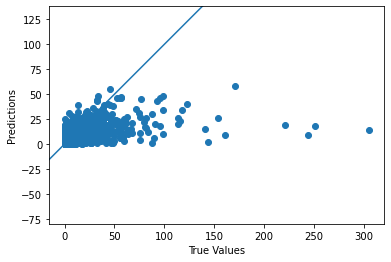

In [65]:
test_predictions = model.predict(test_data)

_ = plt.scatter(test_labels, test_predictions)
_ = plt.xlabel('True Values')
_ = plt.ylabel('Predictions')
_ = plt.axis('equal')
_ = plt.xlim(plt.xlim())
_ = plt.ylim(plt.ylim())
_ = plt.plot([-1000, 1000], [-1000, 1000])

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_errors.png")

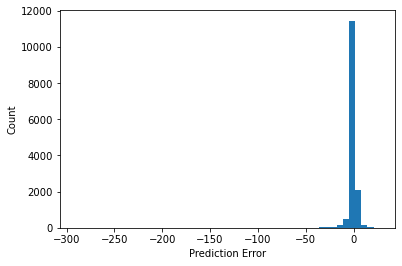

In [66]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")


plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_errors_hist.png")

In [67]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 47.960658625057526


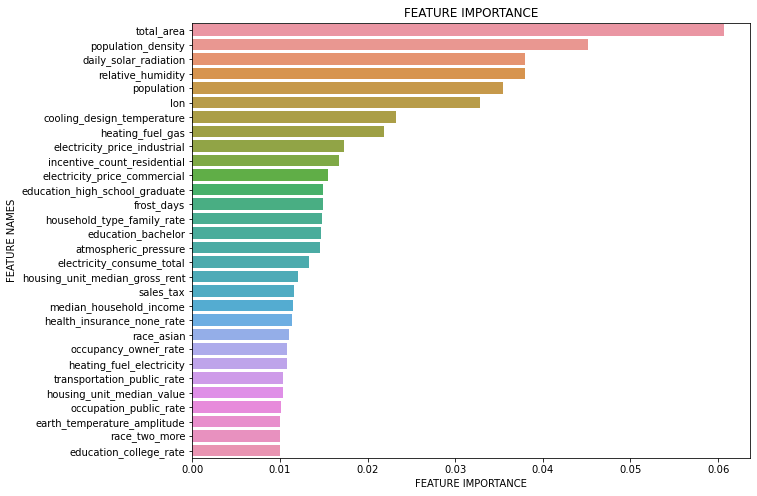

In [68]:
fi_rf = plot_feature_importance(model.feature_importances_, train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_feature_importance.png")

In [69]:
# model = RandomForestRegressor(**params_rfr)

# parameters = {'criterion':['squared_error'],
#               'n_estimators': [300,500,600, 1000],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [7,10,20],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 5],
#               'bootstrap': [True, False]}
# random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
#                                            n_iter=50, cv=5, verbose=3, random_state=seed,
#                                            n_jobs=-1, scoring = 'neg_mean_absolute_error')
# random_search.fit(train_data, train_labels)


In [70]:
# random_search.best_params_

In [71]:
# params_rfr = {'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 5,
#  'max_features': 'sqrt',
#  'max_depth': 20,
#  'criterion': 'squared_error',
#  'bootstrap': False}
# model = RandomForestRegressor(**params_rfr)

In [72]:
# %%time
# model.fit(train_data, train_labels)

In [73]:
# mse = mean_squared_error(test_labels, test_predictions)
# print(f'the mse is {mse}')

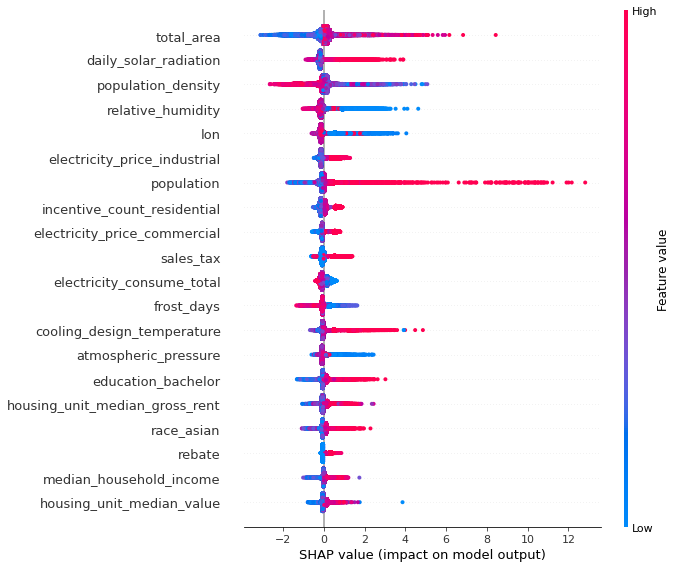

<Figure size 432x288 with 0 Axes>

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data, approximate=True)
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/rf_nonresidential_system_count_shap.png")

# Neural Network Regression

In [56]:
#Split the encoded data into train and test sets
#x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=seed)


In [75]:
from tensorflow import keras

In [76]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
#     keras.layers.Dense(128, activation=tf.nn.relu,
#                        name='hidden_layer_2',),
#     keras.layers.Dense(128, activation=tf.nn.relu,
#                        name='hidden_layer_3',),
    #keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 13,441
Trainable params: 13,441
Non-trainable params: 0
_________________________________________________________________


2021-12-16 08:31:15.309550: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [77]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sq. Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

2021-12-16 08:31:57.128320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



.............................

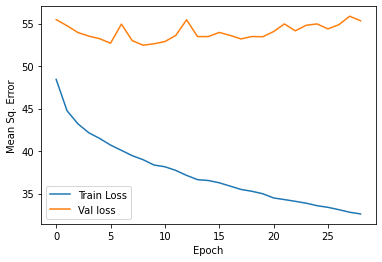

In [78]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [81]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      52


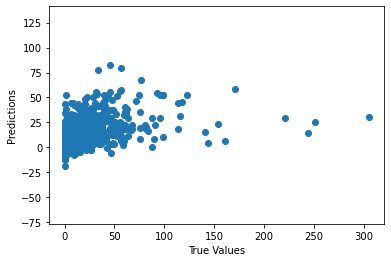

In [82]:
test_predictions = model.predict(test_data).flatten()

_ = plt.scatter(test_labels, test_predictions)
_ = plt.xlabel('True Values')
_ = plt.ylabel('Predictions')
_ = plt.axis('equal')
_ = plt.xlim(plt.xlim())
_ = plt.ylim(plt.ylim())
#_ = plt.plot([-1000, 1000], [-1000, 1000])

# Deep learning

In [83]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3',),
#     keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sq. Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


.......................

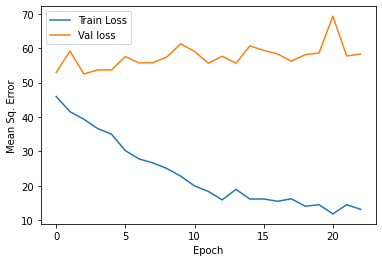

In [85]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [86]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      54


In [87]:
#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',kernel_regularizer=tf.keras.regularizers.L2(2.)),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3'),
#     keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



.........................

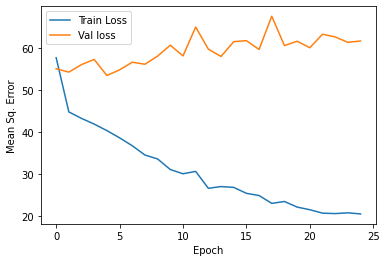

In [88]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [89]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      54


In [119]:
#regularizers.l1_l2(l1=1e-5, l2=1e-4)

#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dropout(.2),
    keras.layers.Dense(16, activation=tf.nn.relu,
                       name='hidden_layer_2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=.4, l2=3)),
    keras.layers.Dense(16, activation=tf.nn.relu,
                       name='hidden_layer_3',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=.4, l2=3)),
#     keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 16)                1664      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 16)                272       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________



..............................................................

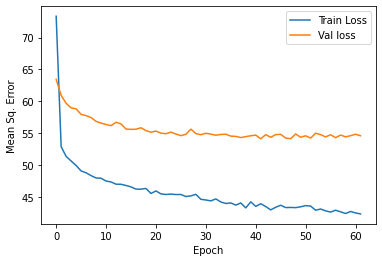

In [120]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [122]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:      51


In [131]:
explainer = shap.KernelExplainer(model.predict,shap.sample(train_data, 100))

In [132]:
shap_values = explainer.shap_values(shap.sample(train_data,100), approximate=True)


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

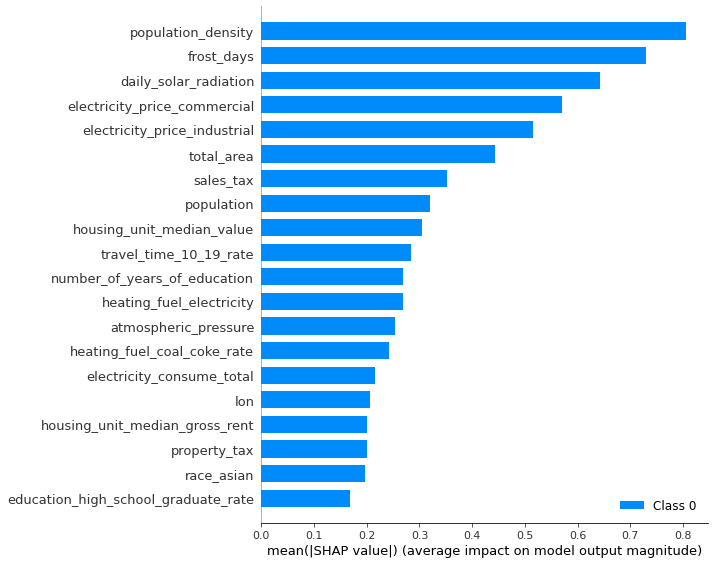

In [133]:
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)